In [21]:
# toggle between "notebook" and "inline", if graphs are not directly displayes
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

from matplotlib.patches import ConnectionPatch
from matplotlib.legend import Legend
from matplotlib.patches import Rectangle

from statannot import add_stat_annotation
from statannotations.Annotator import Annotator

import calour as ca
ca.set_log_level(40)

from ggmap.workflow import *

ggmap is custome code from Stefan Janssen, download at https://github.com/sjanssen2/ggmap, using commit '4f50329dac26ba287fb5552d9e0ca250bd6887ca'
Reading settings file '/homes/sjanssen/.ggmaprc'


In [4]:
# an ugly mechanism to list my currently installes packages
cluster_run(['conda list > conda_list', 'rm -f dummy'], 
            'get_packages', 
            './dummy', 
            dry=False, use_grid=False, environment='notebookServer')
!cat conda_list

# packages in environment at /homes/sjanssen/miniconda3/envs/notebookServer:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
alsa-lib                  1.2.8                h166bdaf_0    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
argon2-cffi               21.3.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py310h5764c6d_3    conda-forge
asttokens                 2.2.1              pyhd8ed1ab_0    conda-forge
attr                      2.5.1                h166bdaf_1    conda-forge
attrs                     22.2.0             pyh71513ae_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                pyhd8e

## Definitions

In [5]:
NA_VALUES = ['not applicable', 'not collected', 'not provided']
ORDER_GENERATIONS = ['RM','P','F1','F2','F3','F4','F5','Controls']
KEY_GENERATIONS = lambda x: x.apply(lambda a: ORDER_GENERATIONS.index(a))
ORDER_TAXPLOT = ['Janvier B6J', 'Duesseldorf B6J', 'F5_B2', 'F5_B3', 'F4_B1', 'F4_B2', 'F4_B3', 'F3_B1', 'F3_B2', 'F3_B3', 'F2_B1', 'F2_B2', 'F2_B3', 'F1_B1', 'F1_B2', 'F1_B3', 'P_B1', 'P_B2', 'P_B3', 'RM', 
                 'P_C1', 'P_C2', 'F1_C1', 'F1_C2', 'F2_C1', 'F2_C2', 'F3_C1', 'F3_C2', 'F3_C3', 'F4_C1', 'F4_C2', 'F4_C3', 'F5_C1', 'F5_C2', 'F5_C3', 'Duesseldorf C', 'Janvier C', ]
KEY_TAXPLOT = lambda x: x.apply(lambda a: ORDER_TAXPLOT.index(a))

ORDER_GENOTYPE = ['B6J', 'C']
COLORS = {
    'B6J': '#0000ff',
    'C': '#f27304',
    "RM": "#ff0000",
    
    'P': '#8e0152',
    'F1': '#d6589e',
    'F2': '#f5c4e1',
    'F3': '#c7e89f',
    'F4': '#6eae36',
    'F5': '#276419',
    
    'mJAX': '#ff0000',
    'mTAC': '#0000ff',
    
    "B1": "#deebf7", 
    "B2": "#9ecae1", 
    "B3": "#3182bd",
    "C1": "#fee8c8",
    "C2": "#fdbb84",
    "C3": "#e34a33",
}
DM_NAMES = {
    'PD_whole_tree': "Faith's PD",
    'unweighted_unifrac': 'unweighted UniFrac',
    'weighted_unifrac': 'weighted UniFrac',
}

def alpha_blending(hex_color, alpha) :
    """ alpha blending as if on the white background.
    """
    foreground_tuple  = matplotlib.colors.hex2color(hex_color)
    foreground_arr = np.array(foreground_tuple)
    final = tuple( (1. -  alpha) + foreground_arr*alpha )
    return(final)

def _sample_level(sample, field='cage_line', just_host_genotype=False):
    """Assign sample categories based on multiple selected metadata fields"""
    if pd.notnull(sample[field]):
        if just_host_genotype:
            return sample['host_genotype']
        else:
            return sample[field]
    if sample['host_genotype'] == 'RM':
        return sample['host_genotype']
    if pd.notnull(sample['control']):
        return '%s %s' % (sample['control'], sample['host_genotype'])


## Obtain data

Data are managed with Qiita as the public study with ID 13422. You can obtain all necessary data through three alternative ways:

(Note: the ITS sequencing to profile fungi was not successful, i.e. too low read qualities. Ignore this preparation in Qiita!)

1. per sample forward and reverse fastq.gz files from ENA, accession LINK
2. metadata and precomputed feature table (bacteria * samples) from our public Qiita study: [https://qiita.ucsd.edu/study/description/13422](https://qiita.ucsd.edu/study/description/13422). fastq.gz files are also available through Qiita.
3. **metadata and precomputed feature table (bacteria * samples) via [github](https://github.com/jlab/microbiome_benga_multiplegenerations), which are actually downloaded from Qiita for your convenience**

The per sample forward and reverse fastq.gz result from: base calling and simultaneous demultiplexing was done via bcl2fastq (v2.19.0.316) and primers were trimmed using cutadapt (v2.10, Martin 2011).

In [38]:
# obtain metadata from Qiita as the combination of "Sample Info" and "Prep Info"
metadata = pd.concat([pd.read_csv("FromQiita/%s" % filename, sep="\t", dtype=str, na_values=NA_VALUES, index_col=0)
                      for filename in ["13422_prep_11649_20220103-015657.txt",  # Prep Info
                                       "13422_20231103-093637.txt"              # Sample Info
                                      ]], axis=1)

# make values true numbers
metadata['serum_triglyceride'] = metadata['serum_triglyceride'].astype(float)

metadata['gave_birth'] = metadata['gave_birth'].astype(bool)
metadata['mate_sire'] = metadata['mate_sire'].astype(bool)

# use abbreviations for "host genotype" as in the manuscript
metadata['host_genotype'] = metadata['host_genotype'].apply(lambda x: {'c57bl6/j': 'B6J',
                                                                       'balb/c': 'C',
                                                                       'b6cf1': 'RM'}.get(x, x))
metadata['cage_line'] = metadata['cage_line'].apply(lambda x: {'C57BL6/J_line1': 'B1',
                                                               'C57BL6/J_line2': 'B2',
                                                               'C57BL6/J_line3': 'B3',
                                                               'BALB/c_line4': 'C1',
                                                               'BALB/c_line5': 'C2',
                                                               'BALB/c_line6': 'C3',}.get(x,x))

# give locations shorter names
metadata['geo_loc_name'] = metadata['geo_loc_name'].apply(lambda x: {'France:Janvier': 'Janvier',
                                                                     'Germany:Duesseldorf': 'Duesseldorf'}.get(x,x))

# provide extra field to easily identify control (Janvier / Duesseldorf) samples
metadata['control'] = metadata[(metadata['host_scientific_name'] == 'mus musculus') &
                               ((metadata['geo_loc_name'] == 'Janvier') |
                               (metadata['iacuc_institute'] == 'ZETT'))]['geo_loc_name'].apply(lambda x: {'Janvier': 'Janvier',
                                                                                                          'Duesseldorf': 'Duesseldorf'}.get(x, np.nan))

metadata['sample_category'] = metadata.apply(lambda x: _sample_level(x, 'cage_line', True), axis=1)
metadata['sample_category_cagelines'] = metadata.apply(lambda x: _sample_level(x, 'cage_line', False), axis=1)
metadata['sample_category_generation'] = metadata.apply(lambda x: _sample_level(x, 'generation', False), axis=1)
metadata['generation_cageline'] = metadata.apply(lambda row: '%s%s' % (row['generation'] if pd.notnull(row['generation']) else row['sample_category'],
                                                                       '_' + row['cage_line'] if pd.notnull(row['cage_line']) else ''), axis=1)
metadata['independent_cage_lineage'] = metadata['cage_line'].apply(lambda x: x[-1] if pd.notnull(x) else x)

metadata['serum_triglyceride'] = metadata['serum_triglyceride'].astype(float)

In [39]:
# subset metadata to gut and skin, as we rarefy these samples differently to account for different 
# read coverage due to low biomass in skin

meta_gut = metadata[(metadata['host_scientific_name'] == 'mus musculus') &  # ignore marmoset control samples
                    (metadata['host_body_site'] == 'uberon:colon')]         # only select gut

meta_skin = metadata[(metadata['host_scientific_name'] == 'mus musculus') &           # ignore marmoset control samples
                     (metadata['host_body_site'] == 'uberon:skin of external ear') &  # only select skin
                     (metadata['batch'] != '2')]                                      # 12 skin samples have been sequenced twice, just use the better quality run

# same for the feature table
counts = biom2pandas("FromQiita/128106_reference-hit.biom")
counts_gut = counts.loc[:, meta_gut.index]
counts_skin = counts.loc[:, meta_skin.index]

## Rarefy, assign taxonomy & compute alpha- and beta- diversities

In [8]:
sepp_tree = TreeNode.read("FromQiita/128106_insertion_tree.relabelled.tre", format="newick")

**Note:** rarefaction is an inherently randomized process, i.e. if you re-compute from scratch, you will probably find small differences to the published version.

In order to provide you with almost identical results, we packaged cached results that are affected by rarefaction into the repository. Should you NOT want to use them, remove all file in the hidden subdirectory `.anacache`.

Information: 15572 of 16581 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/c8cc907120a605fd111f28cbbcdc3132.taxRDP'. 
Using existing results from '.anacache/5179d20c06f5c00b1eaf5f1360ee9164.rare'. 
Using existing results from '.anacache/d5aac03be52015ef7863d88178fad830.rarefy'. 
Using existing results from '.anacache/1f8ed008c9f4b329008432d202e2d6bf.adiv'. 
Using existing results from '.anacache/198f924e091ede0f8d82057a1226ffec.bdiv'. 
Using existing results from '.anacache/e8547774776b3bb4c13ec2d8722d0565.emperor'. 
Your final feature table is composed of 333 samples and 990 features.


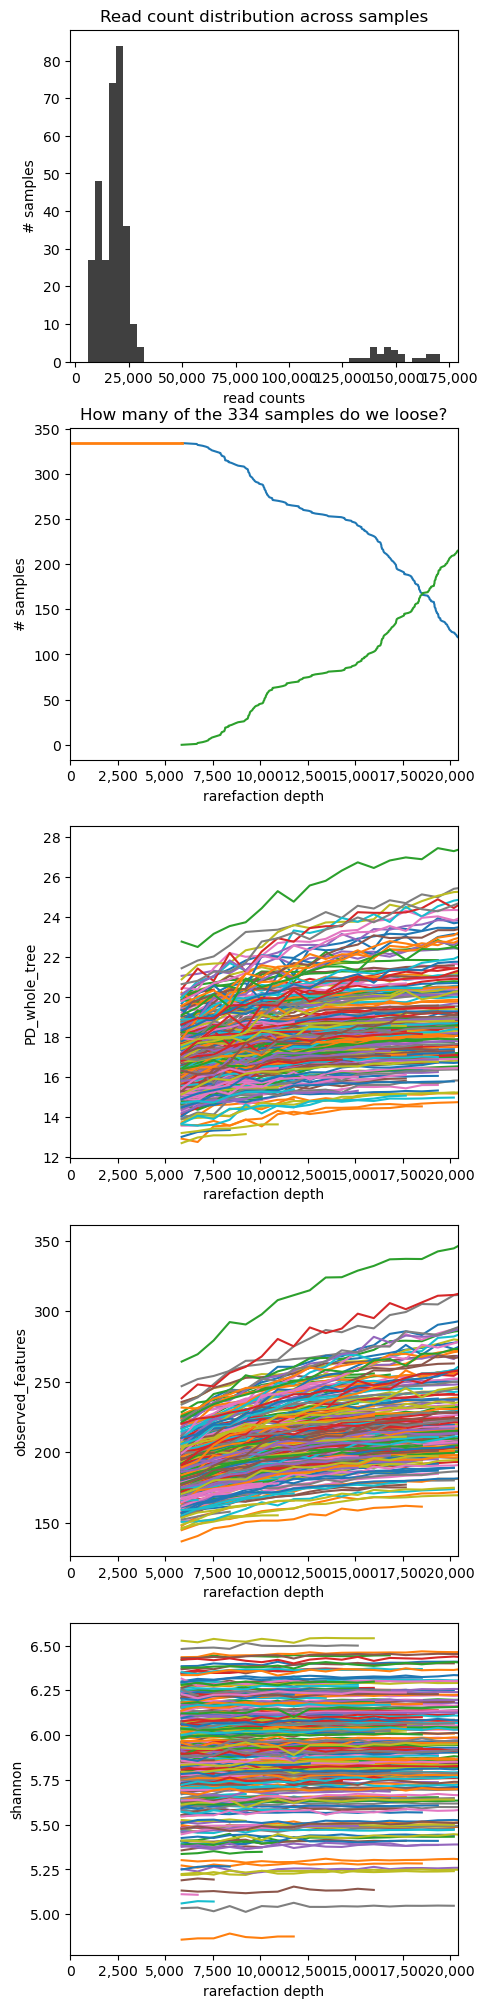

In [22]:
res_gut = process_study(
    metadata=meta_gut,
    control_samples=set([]),  # we already filtered out all control samples
    fp_deblur_biom=counts_gut,  # "abuse" argument to provide a table instead of a filepath
    fp_insertiontree="FromQiita/128106_insertion_tree.relabelled.tre",
    rarefaction_depth=6000,
    fp_taxonomy_trained_classifier="/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg_2022_10_backbone_full_length.nb_2023.5.qza",  # obtain this file from https://docs.qiime2.org/2023.9/data-resources/
    tree_insert=sepp_tree,
    is_v4_region=False,
    emperor_fp='Generated/Emperor',
    emperor_infix='_gut',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    emperor_skip_tsne_umap=True,
)

Information: 13989 of 16581 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/55396ded28375658d78d971ed88c6a21.taxRDP'. 
Using existing results from '.anacache/6adc5645aa4b136bf6ed546e9a7f2b1d.rare'. 
Using existing results from '.anacache/2e4a58549011d1f26babdfab1a113f18.rarefy'. 
Using existing results from '.anacache/bcc400eafedd76a1bb8f9a9fd348f250.adiv'. 
Using existing results from '.anacache/57ff78d0579e660989d3aaa50ed7df98.bdiv'. 
Using existing results from '.anacache/bfbd2408f17461fab81cad1833e3d4d8.emperor'. 
Your final feature table is composed of 274 samples and 2581 features.


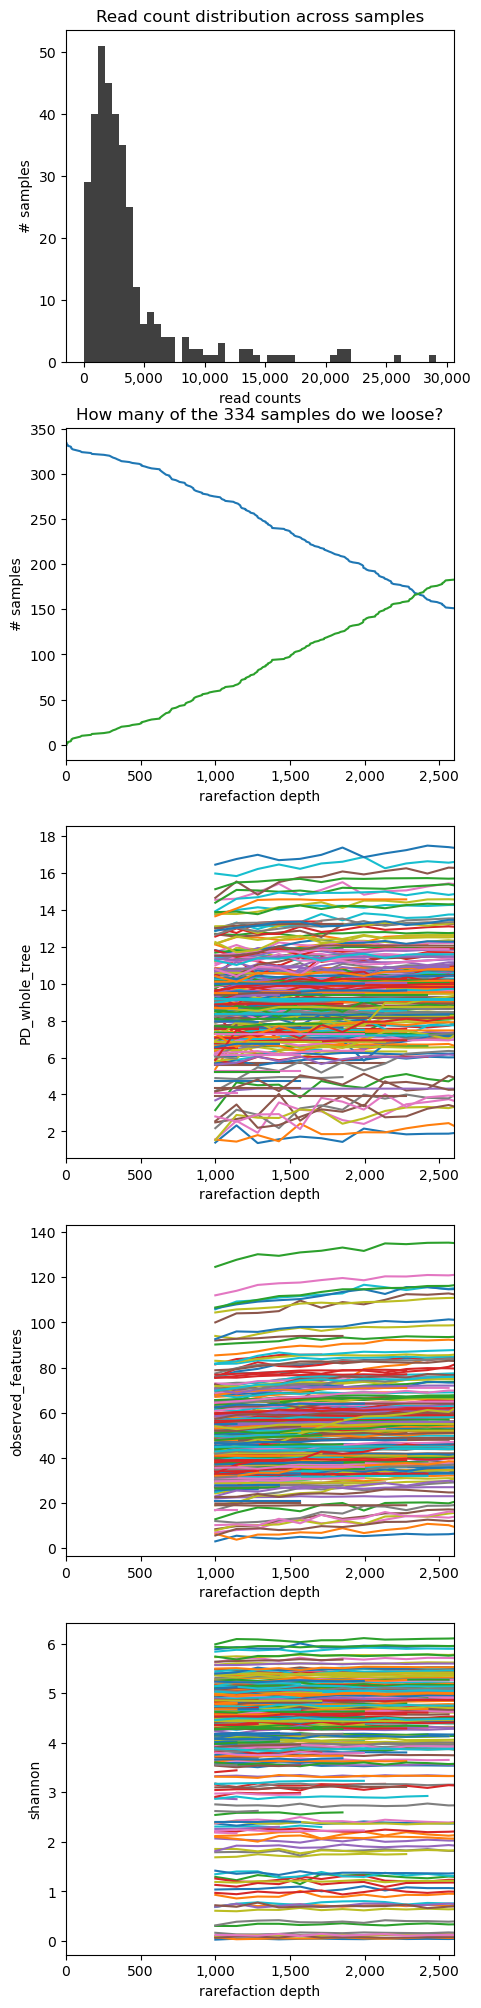

In [23]:
res_skin = process_study(
    metadata=meta_skin,
    control_samples=set([]),  # we already filtered out all control samples
    fp_deblur_biom=counts_skin,  # "abuse" argument to provide a table instead of a filepath
    fp_insertiontree="FromQiita/128106_insertion_tree.relabelled.tre",
    rarefaction_depth=1000,
    fp_taxonomy_trained_classifier="/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg_2022_10_backbone_full_length.nb_2023.5.qza",  # obtain this file from https://docs.qiime2.org/2023.9/data-resources/
    tree_insert=sepp_tree,
    is_v4_region=False,
    emperor_fp='Generated/Emperor',
    emperor_infix='_skin',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    emperor_skip_tsne_umap=True,
)

Information: 13174 of 16581 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/bca9ebfbf4293a89b622a5a2e9756ff8.taxRDP'. 
Using existing results from '.anacache/e9c1ed781708e02acf619f978bed34dd.rare'. 
Using existing results from '.anacache/7aa50075a582f32e3e2e19f00cfa2eef.rarefy'. 
Using existing results from '.anacache/b9545ae4fa0caf6bb46e387ea1978a99.adiv'. 
Using existing results from '.anacache/d080fbfd5e057a4f15b5b798b3e8e7da.bdiv'. 
Found 1 temporary working directories, but non of them have finished (missing "finished.info1" file). If no job is currently running, you might want to delete these directories and restart:
  /homes/sjanssen/TMP/ana_emperor_gozdeg5j
Your final feature table is composed of 662 samples and 3083 features.


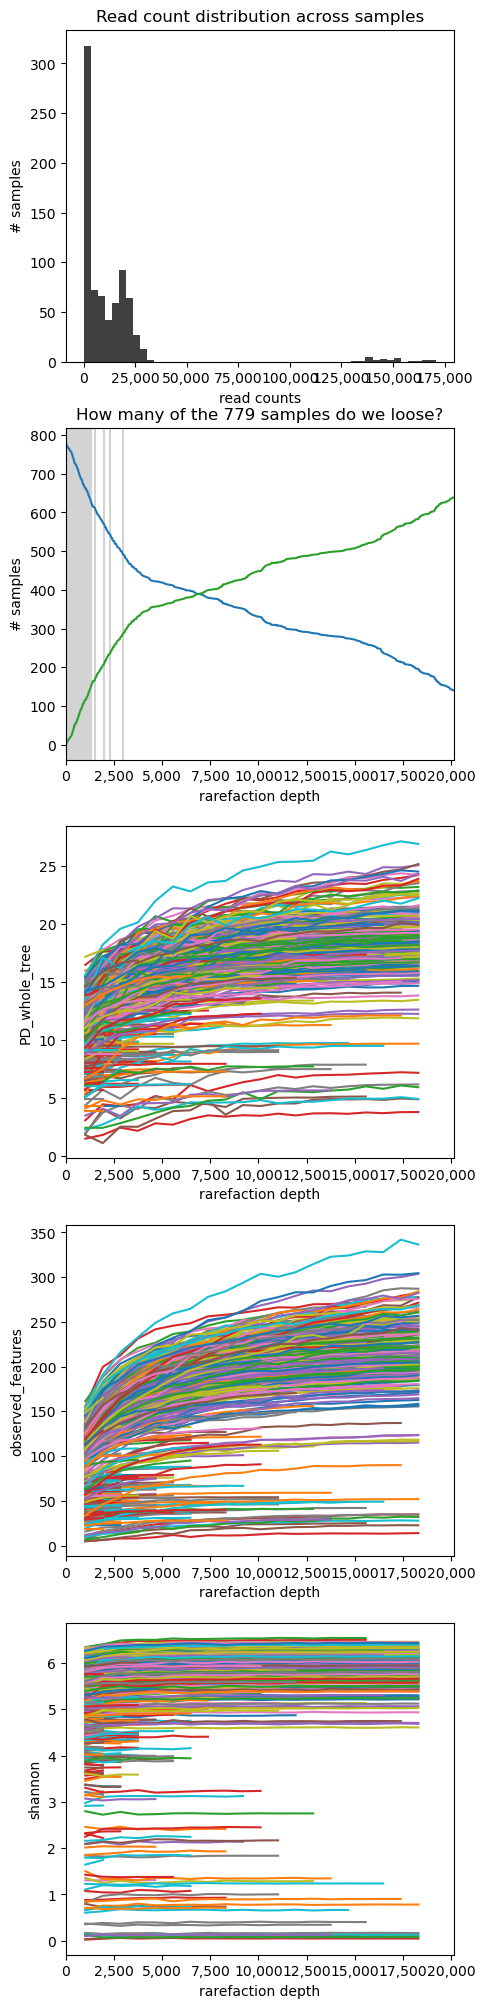

In [24]:
idx_control_samples = set(metadata[metadata['sample_type'].isin(['sterile water', 'control bedding', 'control food'])].index)
res_both = process_study(
    metadata=metadata,
    control_samples=idx_control_samples,
    fp_deblur_biom=counts,  # "abuse" argument to provide a table instead of a filepath
    fp_insertiontree="FromQiita/128106_insertion_tree.relabelled.tre",
    rarefaction_depth=1000,
    fp_taxonomy_trained_classifier="/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg_2022_10_backbone_full_length.nb_2023.5.qza",  # obtain this file from https://docs.qiime2.org/2023.9/data-resources/
    tree_insert=sepp_tree,
    is_v4_region=False,
    emperor_fp='Generated/Emperor',
    emperor_infix='_both',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    emperor_skip_tsne_umap=True,
    skip_rarefaction_curves=False,
)

In [40]:
# drop samples from metadata which did not pass QC, i.e. rarefaction
meta_gut = meta_gut.loc[res_gut['rarefaction']['results'].columns, :]
meta_skin = meta_skin.loc[res_skin['rarefaction']['results'].columns, :]

## Figure 2
### Panel A
  1. Browse to view.qiime2.org and upload the file `Generated/Emperor/emperor-pcoa_gut_weighted_unifrac.qzv`. 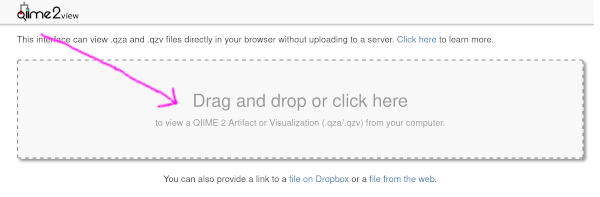
  2. right click on the 3D animation to open the context menu 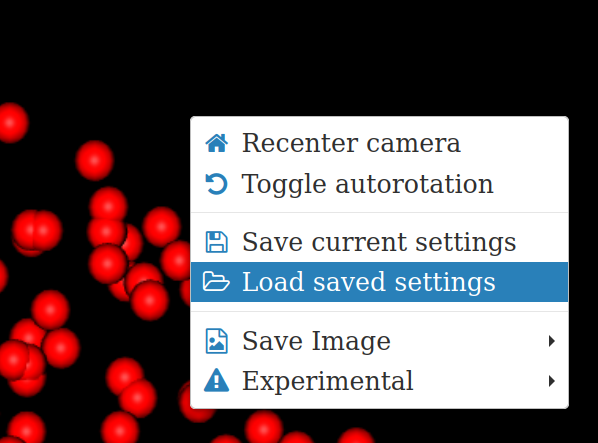
  3. choose `Load saved settings` and select the file `EmperorSettings/emp_settings_gut_panelA.json`
  
This is a screenshot of how your browser should render the interactive Emperor plot:
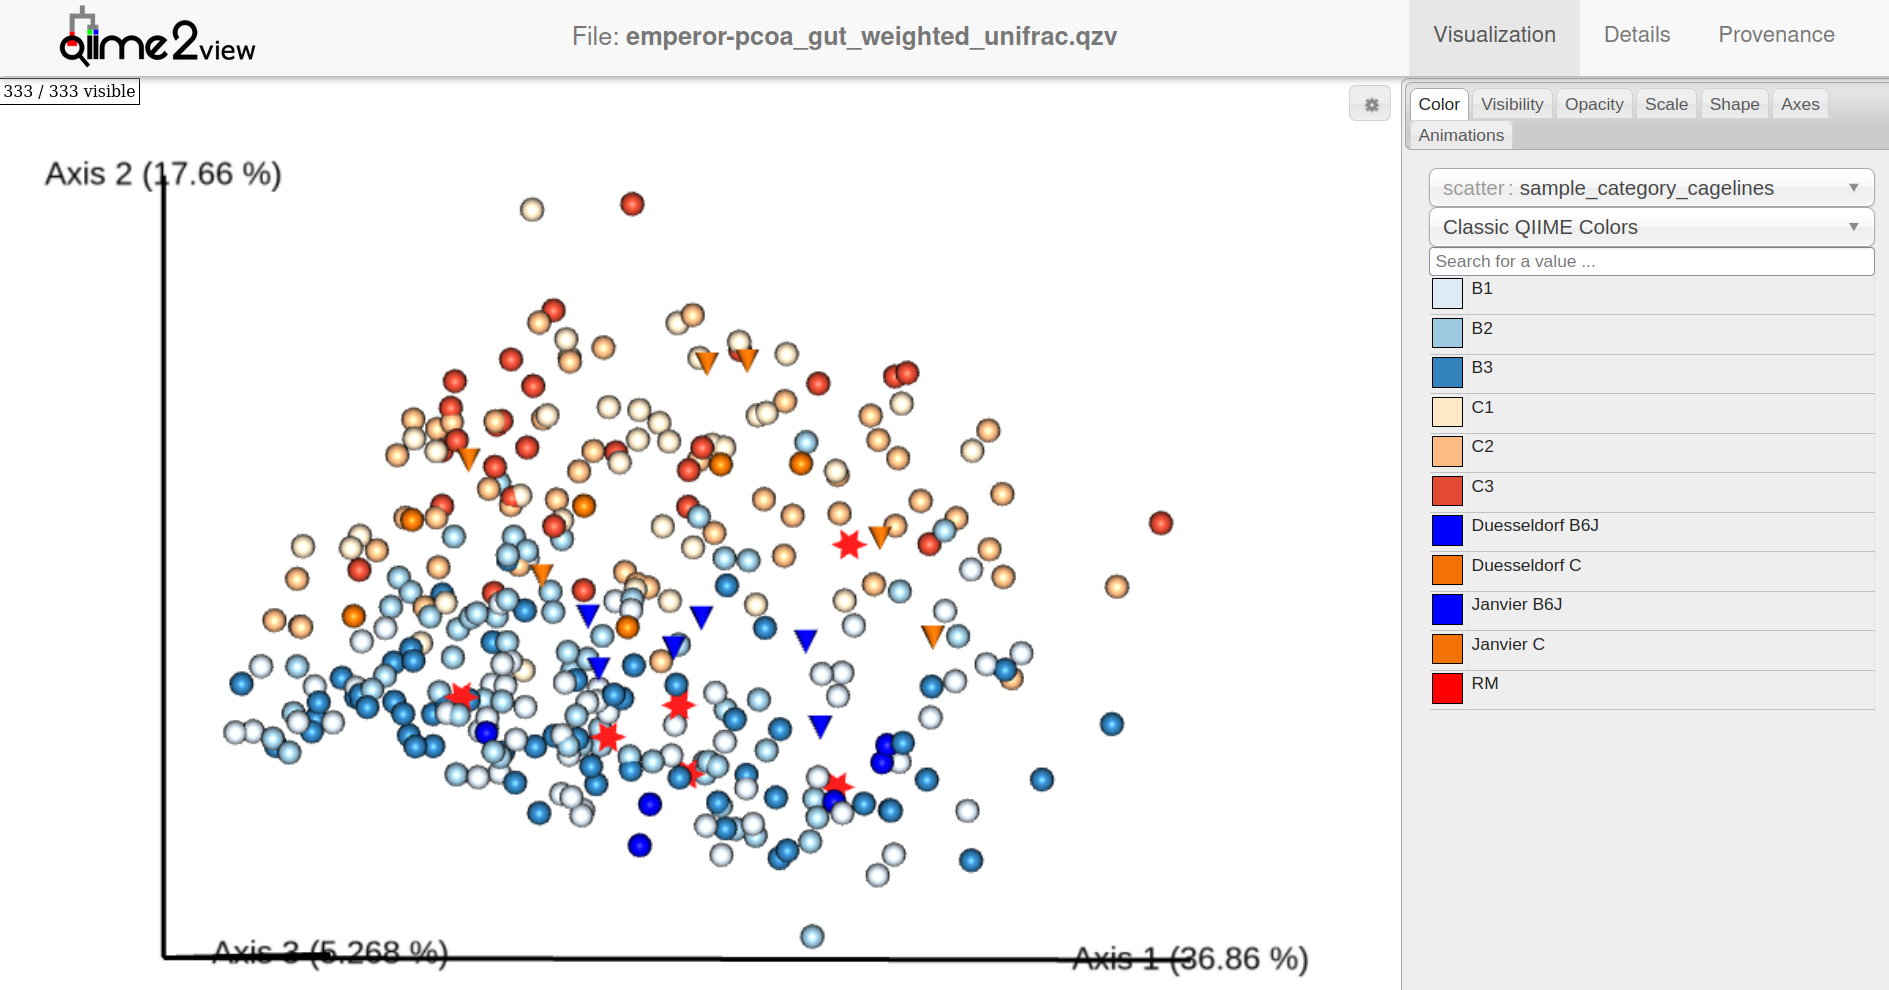

### Panel B
see above, but load settings from file `EmperorSettings/emp_settings_gut_panelB.json`
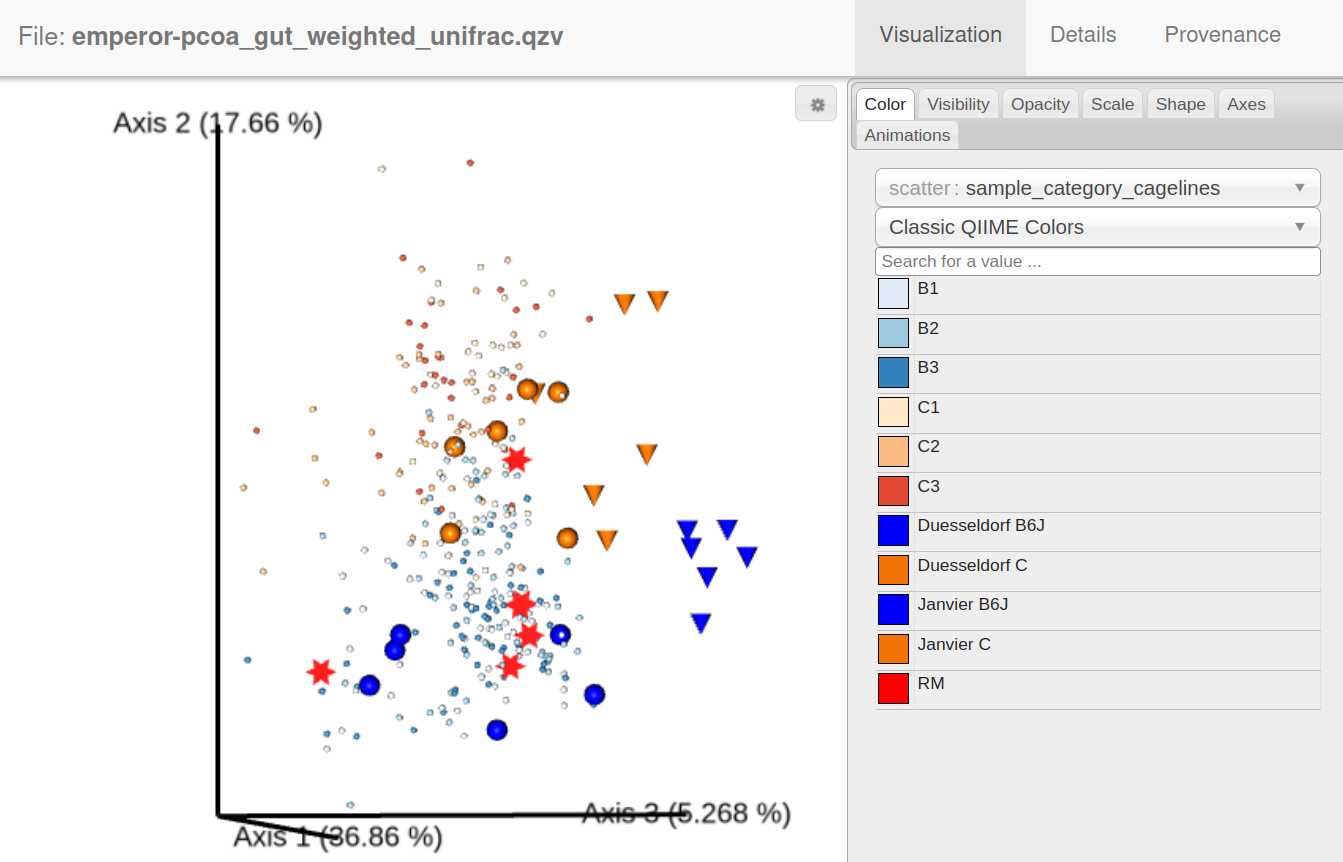

### Panel C
see above, but load settings from file `EmperorSettings/emp_settings_gut_panelC.json`
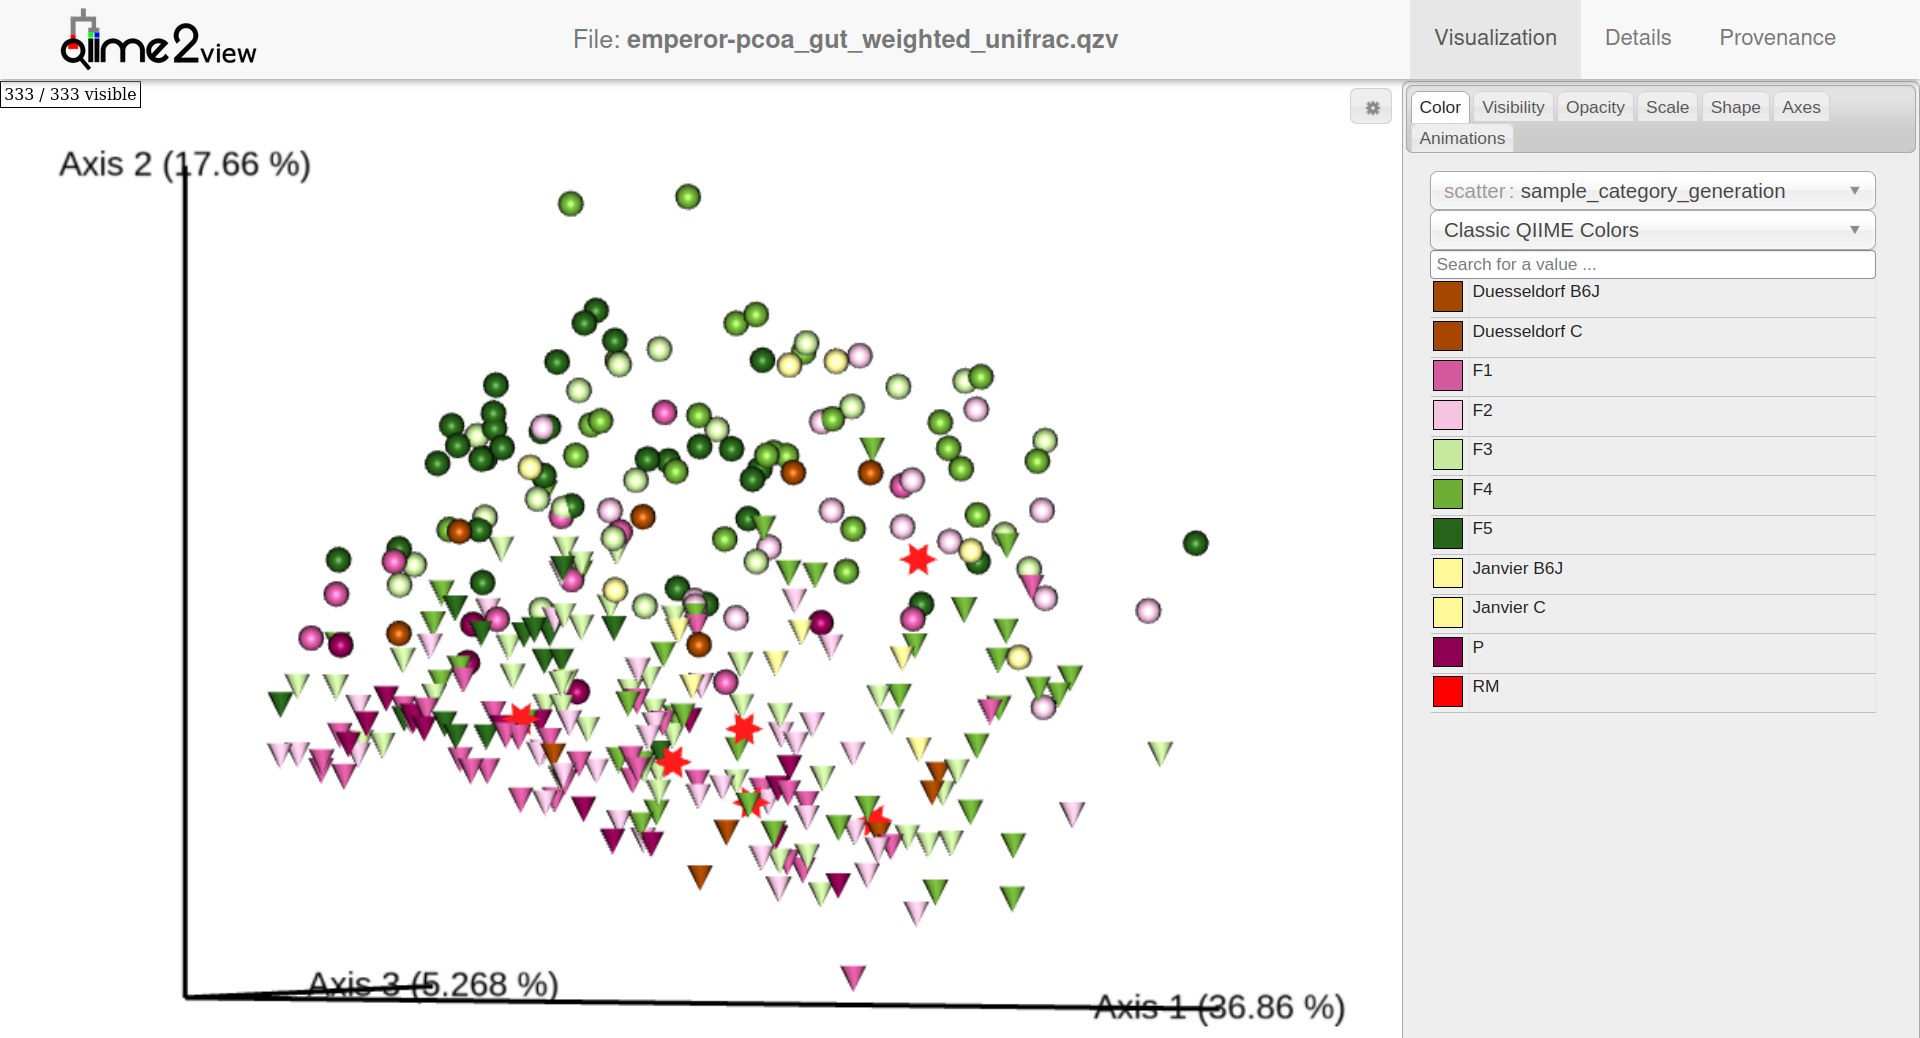

### Panel D
see above, but load settings from file `EmperorSettings/emp_settings_gut_panelD.json`
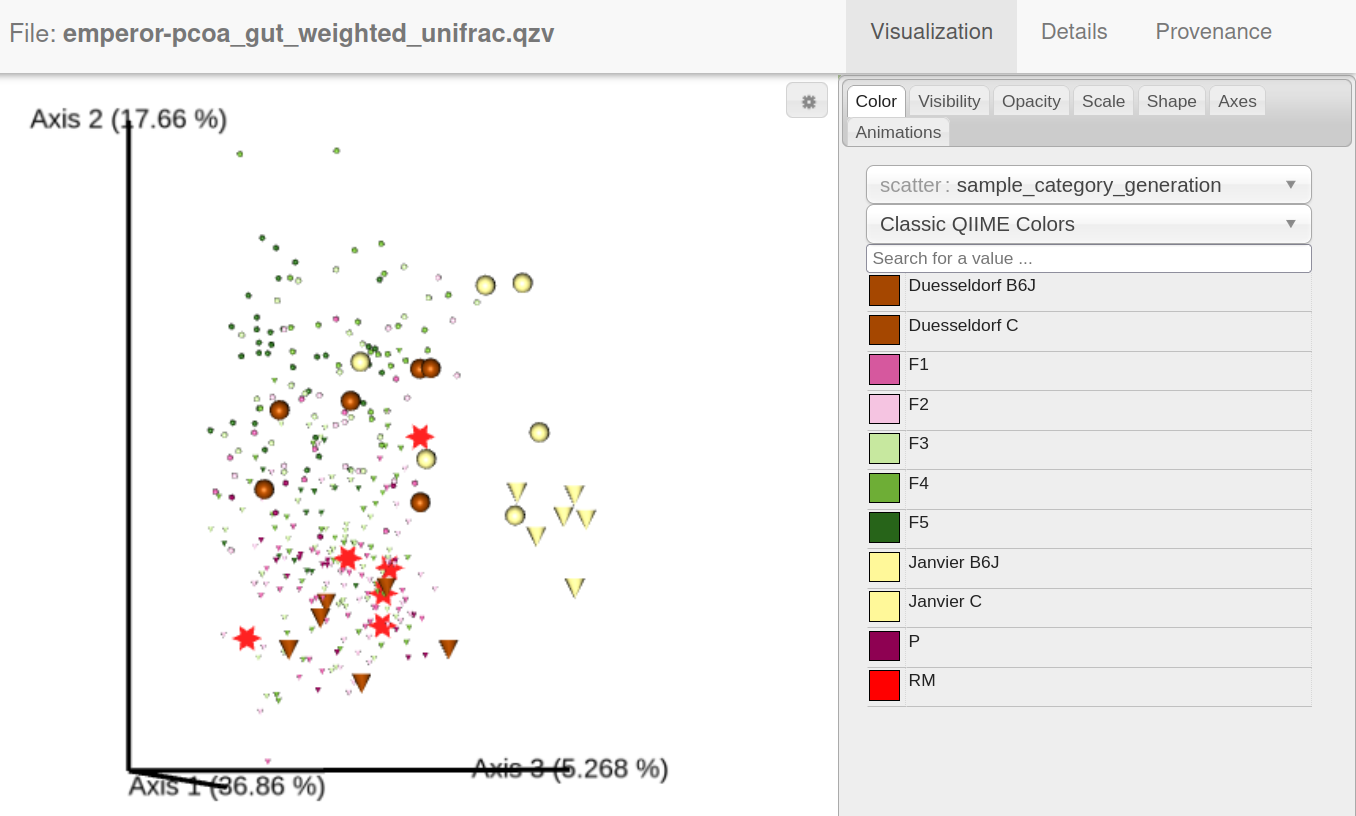

## Figure 3
### Panels A,B,C

In [41]:
def get_sample_numbers(meta):
    # collect number of samples: individuals, cages, cage_lines
    assert meta['host_subject_id'].value_counts().max() == 1
    
    numSamples = pd.concat([
        # breeding experiment
        pd.concat([
            meta.groupby(['generation', 'host_genotype']).size().rename('i'),  # individuals
            meta.groupby(['generation', 'host_genotype'])['cage_id'].unique().apply(len).rename('c'),  # cages
            meta.groupby(['generation', 'host_genotype'])['cage_line'].unique().apply(len).rename('l')  # cage-lines
        ], axis=1),
        # controls
        pd.concat([
            meta[pd.isnull(meta['generation'])].groupby(['geo_loc_name', 'host_genotype']).size().rename('i'),  # individuals
            meta[pd.isnull(meta['generation'])].groupby(['geo_loc_name', 'host_genotype'])['sex'].unique().apply(len).rename('c'),  # cages. Use sex as a proxy as we actually don't know the cage IDs
            meta[pd.isnull(meta['generation'])].groupby(['geo_loc_name', 'host_genotype'])['cage_line'].unique().apply(lambda x: np.nan).rename('l')  # we did not use cage lines for controls
        ], axis=1)
    ])
    
    return numSamples

def get_sample_label(grp, numSamples, genotypes=ORDER_GENOTYPE):
    label = ""
    if grp == 'RM':
        genotypes = ['RM']
    for genotype in genotypes:
        cat = dict()
        for category in ['i','c','l']:
            number = numSamples.loc[(grp, genotype), category]
            if pd.notnull(number):
                cat[category] = '%2i%s' % (number, category)
            else:
                cat[category] = number
        if pd.isnull(cat['l']):
            ns = '%s (%s)' % (cat['i'], cat['c'])
        else:
            ns = '%s (%s,%s)' % (cat['i'], cat['c'], cat['l'])
        label += "\n" + ns
    return label

def compute_beta_distances(res_beta, meta, metric='weighted_unifrac'):
    results = dict()

    dm = res_beta[metric].to_data_frame()
    data = []
    for refgrp, g_ref in meta[~meta['sample_category'].isin(['C'])].groupby('sample_category'):
        for (host_genotype, generation), g in meta[meta['sample_category'].isin(['C','B6J','RM'])].groupby(['sample_category', 'generation']):
            subset_g_ref = g_ref
            if refgrp == host_genotype:
                continue
            if refgrp == 'B6J':
                subset_g_ref = g_ref[g_ref['generation'] == generation]
            assert len(set(subset_g_ref.index) & set(g.index)) == 0
            d = dm.loc[subset_g_ref.index, g.index].stack().to_frame().reset_index().rename(columns={0: metric, 'level_0': 'idx_reference', 'level_1': 'idx_sample'})
            d['generation'] = generation
            d['host_genotype'] = host_genotype
            d['reference'] = refgrp
            d['reference_host_genotype'] = refgrp.split()[-1]
            d['reference_host_geolocname'] = refgrp.split()[0]
            data.append(d)
    results['beta'] = pd.concat(data).sort_values(by='generation', key=KEY_GENERATIONS)
    
    cids = [cid for (cid, size) in meta.groupby('cage_id').size().items() if size > 1]
    subset = meta[meta['cage_id'].isin(cids)]
    results['intra_cage'] = {'num_cages': len(cids),
                             'sum_mice': subset.shape[0],
                             'avg_mice_per_cage': subset.groupby('cage_id').size().mean(),
                             'avg_%s' % metric: np.mean([dm.loc[a,b] for cage_id, g in subset.groupby('cage_id') for (a,b) in combinations(g.index, 2)])}

    distances = []
    for (generation, host_genotype, cage_line), g in meta.groupby(['generation', 'host_genotype', 'cage_line']):
        for (cageA, cageB) in combinations(g['cage_id'].unique(), 2):
            d = dm.loc[g[g['cage_id'] == cageA].index, g[g['cage_id'] == cageB].index].stack().reset_index().rename(columns={0: metric})
            d[['generation', 'host_genotype', 'cage_line']] = [generation, host_genotype, cage_line]
            distances.append(d)
    distances = pd.concat(distances)
    results['intra_cage_line'] = {'num_cages': meta.groupby(['generation', 'host_genotype', 'cage_line'])['cage_id'].unique().apply(len).sum(),
                                  'avg_cages': meta.groupby(['generation', 'host_genotype', 'cage_line'])['cage_id'].unique().apply(len).mean(),
                                  'sum_mice_mice': distances.shape[0],
                                  'avg_mice_mice': distances.groupby(['generation', 'host_genotype', 'cage_line']).size().mean(),
                                  'avg_%s' % metric: distances[metric].mean(),
                                 }
    return results


def draw_temporals(res, meta, 
                   METRIC_BETA = 'weighted_unifrac', 
                   ALPHA_LIM = (14.5,21.8), 
                   BETA_LIM=(0.085,0.169),
                   title='gut microbiome'):
    #sns.set_style("white")
    numSamples = get_sample_numbers(meta)
    metric = 'PD_whole_tree'
    
    alpha = meta.merge(res['alpha_diversity']['results'], left_index=True, right_index=True)
    beta = compute_beta_distances(res['beta_diversity']['results'], meta, METRIC_BETA)

    sns.reset_orig()
    fig, axes = plt.subplots(3, 3, figsize=(15, 15), gridspec_kw={'width_ratios': [1, 6, 2]})
    fig.subplots_adjust(wspace=0)

    sns.boxplot(data=alpha[alpha['generation'] == 'RM'],
                y=metric, x='host_genotype',
                ax=axes[0,0], color=alpha_blending(COLORS['RM'], 0.4), width=0.4)
    sns.swarmplot(data=alpha[alpha['generation'] == 'RM'],
                  y=metric, x='host_genotype', 
                  ax=axes[0,0], color=COLORS['RM'], size=8, linewidth=1, edgecolor='white')


    data = alpha[(pd.notnull(alpha['generation'])) & (alpha['generation'] != 'RM')].sort_values(by='generation', key=KEY_GENERATIONS)
    sns.lineplot(data=data,
                 y=metric, x='generation', hue='host_genotype', 
                 ax=axes[0,1],sort=False, palette=COLORS, markers=True, marker="o")

    annotator = Annotator(axes[0,1], [
            ((generation, 'B6J'), (generation, 'C')) for generation in data['generation'].unique()
        ], data=data, y=metric, hue='host_genotype', x='generation')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()


    ax = axes[0,2]
    data = alpha[pd.isnull(alpha['generation'])]
    sns.boxplot(data=data,
                y=metric, x='geo_loc_name', hue='host_genotype', 
                ax=axes[0,2], palette={n:alpha_blending(c,0.4) for n,c in COLORS.items()}, hue_order=ORDER_GENOTYPE)
    sns.swarmplot(data=data,
                  y=metric, x='geo_loc_name', hue='host_genotype', 
                  ax=axes[0,2], palette=COLORS, dodge=True, size=8, linewidth=1, edgecolor='white', hue_order=ORDER_GENOTYPE)
    annotator = Annotator(axes[0,2], [
            (('Duesseldorf', 'B6J'), ('Duesseldorf', 'C')),
            (('Janvier', 'B6J'), ('Janvier', 'C'))
        ], data=data, y=metric, hue='host_genotype', x='geo_loc_name')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # ignore warning, as we do not split data into hue category
        annotator = Annotator(axes[0,2], [
                    ('Duesseldorf', 'Janvier')
                ], data=data, y=metric, x='geo_loc_name')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()

    axes[0,1].add_artist(ConnectionPatch(xyA=(0,ALPHA_LIM[0]+1), xyB=(0,ALPHA_LIM[0]+1), coordsA="data", coordsB="data",
                          axesA=axes[0,0], axesB=axes[0,1], color="black"))
    axes[0,0].text(0, ALPHA_LIM[0]+0.7, "p=%.3f" % kruskal(alpha[alpha['generation'] == 'RM'][metric], alpha[(alpha['generation'] == 'P')][metric]).pvalue)



    # figure aestetics
    axesTop = [axes[0,i].twiny() for i in range(len(axes[0]))]
    axesTop[0].set_xticks([0.5], ['%s\n\n' % get_sample_label('RM', numSamples)])
    axesTop[1].set_xlim(axes[0,1].get_xlim())
    axesTop[1].set_xticks(axes[0,1].get_xticks())
    axesTop[1].set_xticklabels(['\n%s' % get_sample_label(t.get_text(), numSamples) for t in axes[0,1].get_xticklabels()])
    axesTop[2].set_xlim(axes[0,2].get_xlim())
    offset = 0.2
    axesTop[2].set_xticks([0-offset,0+offset, 1-offset, 1+offset], 
                          ['\n%s\n' % get_sample_label('Duesseldorf', numSamples, genotypes=['B6J']),
                           '\n\n%s' % get_sample_label('Duesseldorf', numSamples, genotypes=['C']),
                           '\n%s\n' % get_sample_label('Janvier', numSamples, genotypes=['B6J']),
                           '\n\n%s' % get_sample_label('Janvier', numSamples, genotypes=['C'])])

    axes[0,2].set_title('Controls')
    axes[0,2].legend().remove()
    for ax in axes[0]:
        # same y limits for all three subplots
        ax.set_ylim(ALPHA_LIM)
        # add horizontal grid lines ...
        ax.set_axisbelow(True)
        # ... behind the plots
        ax.grid(axis='y')
        # no x axis label, as we already have tick labels
        ax.set_xlabel("")

        if ax == axes[0,0]:
            # nice label for Y axis
            ax.set_ylabel('α diversity\n%s' % DM_NAMES.get(metric))
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])

           
    ## SECOND ROW: beta diversity distances to RM
    for ax in [axes[1,0], axes[1,1]]:
        ax.axhline(y=beta['intra_cage']['avg_%s' % METRIC_BETA], linestyle='--', label='avg. intra cage', color=sns.color_palette()[7])
        ax.axhline(y=beta['intra_cage_line']['avg_%s' % METRIC_BETA], linestyle='dotted', label='avg. intra cage linege', color=sns.color_palette()[5])

    axes[1,1].text(0.2, beta['intra_cage']['avg_%s' % METRIC_BETA]*1.02, '%ic (Σ %ii, Ø %.1fi)' % (
        beta['intra_cage']['num_cages'], 
        beta['intra_cage']['sum_mice'], 
        beta['intra_cage']['avg_mice_per_cage']))
    axes[1,1].text(3.2, beta['intra_cage_line']['avg_%s' % METRIC_BETA]*1.02, 'Σ %ic, Ø %.1fc  Σ %ii-i, Ø %.1fi-i' % (
        beta['intra_cage_line']['num_cages'], 
        beta['intra_cage_line']['avg_cages'], 
        beta['intra_cage_line']['sum_mice_mice'],
        beta['intra_cage_line']['avg_mice_mice']))

    data = beta['beta'][beta['beta']['reference'] == 'RM']
    sns.lineplot(data=data, y=METRIC_BETA, x='generation', hue='host_genotype', ax=axes[1,1], sort=False, palette=COLORS, markers=True, marker="o", hue_order=ORDER_GENOTYPE)
    
    annotator = Annotator(axes[1,1], [
        ((generation, 'B6J'), (generation, 'C')) for generation in data['generation'].unique()
        ], data=data, y=METRIC_BETA, hue='host_genotype', x='generation')
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()
    data = beta['beta'][beta['beta']['reference'] == 'B6J']
    sns.lineplot(data=data, y=METRIC_BETA, x='generation', ax=axes[1,1], sort=False, markers=True, marker="o", color='green', label='CG')

    axes[1,1].set_ylabel("")
    axes[1,1].legend().remove()

    for ax in axes[1]:
        # same y limits for all three subplots
        ax.set_ylim(BETA_LIM)
        # add horizontal grid lines ...
        ax.set_axisbelow(True)
        # ... behind the plots
        ax.grid(axis='y')
        ax.set_xlabel("")

    axes[1,1].set_yticklabels([])
    for i in [1,2]:
        axes[i,0].set_ylabel('β diversity\n%s' % DM_NAMES.get(METRIC_BETA))
    axes[1,0].set_xticks([0.5], ["RM"])
    axes[1, 2].axis('off')


    ## THIRD ROW: beta diversity distances to Controls
    markers_control = {'Janvier': '^', 'Duesseldorf': 'o'}
    data = beta['beta'][~beta['beta']['reference'].isin(['B6J','RM']) & 
                        (beta['beta']['generation'] == 'RM')]
    #sns.lineplot(data=data, y=METRIC_BETA, x='generation', hue='reference_host_genotype', sort=False, ax=axes[2,0], marker="o", style='reference_host_geolocname', palette=COLORS)
    sns.lineplot(data=data, y=METRIC_BETA, x='generation', hue='reference_host_genotype', sort=False, ax=axes[2,0], markers=markers_control, style='reference_host_geolocname', palette=COLORS)
    #sns.boxplot(data=data, y=METRIC_BETA, hue='reference_host_genotype', ax=axes[2,0], x='reference_host_geolocname', palette={n:alpha_blending(c,0.4) for n,c in COLORS.items()}, hue_order=ORDER_GENOTYPE)
    
    for (location, host_genotype), g in data.groupby(['reference_host_geolocname', 'reference_host_genotype']):
        axes[2,0].text(0.0, g[METRIC_BETA].mean(), get_sample_label(location, numSamples, genotypes=[host_genotype]), horizontalalignment='right')
    
    axes[2,0].legend().remove()
    axes[2,0].set_xlim((-1,1))
    for location, g in data.groupby('reference_host_geolocname'):
        #axes[2,0].text(0.01, 0.115 if location == 'Duesseldorf' else 0.145, 'p=%.3f' % kruskal(
        axes[2,0].text(0.01, g[METRIC_BETA].mean(), 'p=%.3f' % kruskal(
            g[(g['reference_host_genotype'] == 'B6J')][METRIC_BETA],
            g[(g['reference_host_genotype'] == 'C')][METRIC_BETA]).pvalue)

    data = beta['beta'][~beta['beta']['reference'].isin(['B6J','RM']) & 
                        (beta['beta']['reference'].apply(lambda x: x.split()[-1]) == beta['beta']['host_genotype'])]
    sns.lineplot(data=data, y=METRIC_BETA, x='generation', hue='reference_host_genotype', sort=False, ax=axes[2,1], markers=markers_control, style='reference_host_geolocname', palette=COLORS)
    axes[2,1].legend().remove()
    
    for ax in axes[2]:
        # same y limits for all three subplots
        ax.set_ylim(BETA_LIM)
        # add horizontal grid lines ...
        ax.set_axisbelow(True)
        # ... behind the plots
        ax.grid(axis='y')
        if ax == axes[2,1]:
            ax.set_xlabel("Generations")
        else:
            ax.set_xlabel("")
    axes[2, 1].set_yticklabels([])

    axes[2, 1].set_ylabel("")
    axes[2, 2].axis('off')
    
    # legend for alpha diversity
    axes[0,1].legend(handles=[
        Line2D([0], [0], marker='o', color=COLORS['RM'], label='RM', linestyle=''),
        Line2D([0], [0], marker='o', color=COLORS['B6J'], label='B6J'),
        Line2D([0], [0], marker='o', color=COLORS['C'], label='C'),
        ],
        title='α diversity', loc='upper left')

    # legend for distance to RM
    axes[1,2].legend(handles=[
        Line2D([0], [0], color=sns.color_palette()[7], label='avg. intra cage', linestyle='--'),
        Line2D([0], [0], color=sns.color_palette()[5], label='avg. intra cage lineage', linestyle='dotted'),
        Line2D([0], [0], marker='o', color=COLORS['B6J'], label='Δ(RM, B6J)'),
        Line2D([0], [0], marker='o', color=COLORS['C'], label='Δ(RM, C)'),
        Line2D([0], [0], marker='o', color='green', label='Δ(B6J, C)'),
        ],
        title='β distance to RM', loc='center')

    # legend for distance to Controls
    axes[2,2].legend(handles=[
        Line2D([0], [0], marker=markers_control['Duesseldorf'], color=COLORS['B6J'], label='Δ(Duesseldorf B6J, RM or B6J)'),
        Line2D([0], [0], marker=markers_control['Duesseldorf'], color=COLORS['C'],   label='Δ(Duesseldorf C, RM or C)'),
        Line2D([0], [0], marker=markers_control['Janvier'], color=COLORS['B6J'], label='Δ(Janvier B6J, RM or B6J)', linestyle='dotted'),
        Line2D([0], [0], marker=markers_control['Janvier'], color=COLORS['C'],   label='Δ(Janvier B6J, RM or C)', linestyle='dotted')],
        title='β distances to Controls', loc='center')

    plt.figtext(0.09, 0.87, 'A', fontsize=16)
    plt.figtext(0.09, 0.6, 'B', fontsize=16)
    plt.figtext(0.09, 0.33, 'C', fontsize=16)
    
    fig.suptitle(title)
    
    return fig

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F1_C vs. F1_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.590e-04 U_stat=5.900e+01
P_C vs. P_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.092e-01 U_stat=2.000e+01
F2_C vs. F2_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.106e-02 U_stat=1.830e+02
F3_C vs. F3_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.582e-07 U_stat=1.220e+02
F4_C vs. F4_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.201e-03 U_stat=2.670e+02
F5_C vs. F5_B6J: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.412e-01 U_stat=2.190e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-

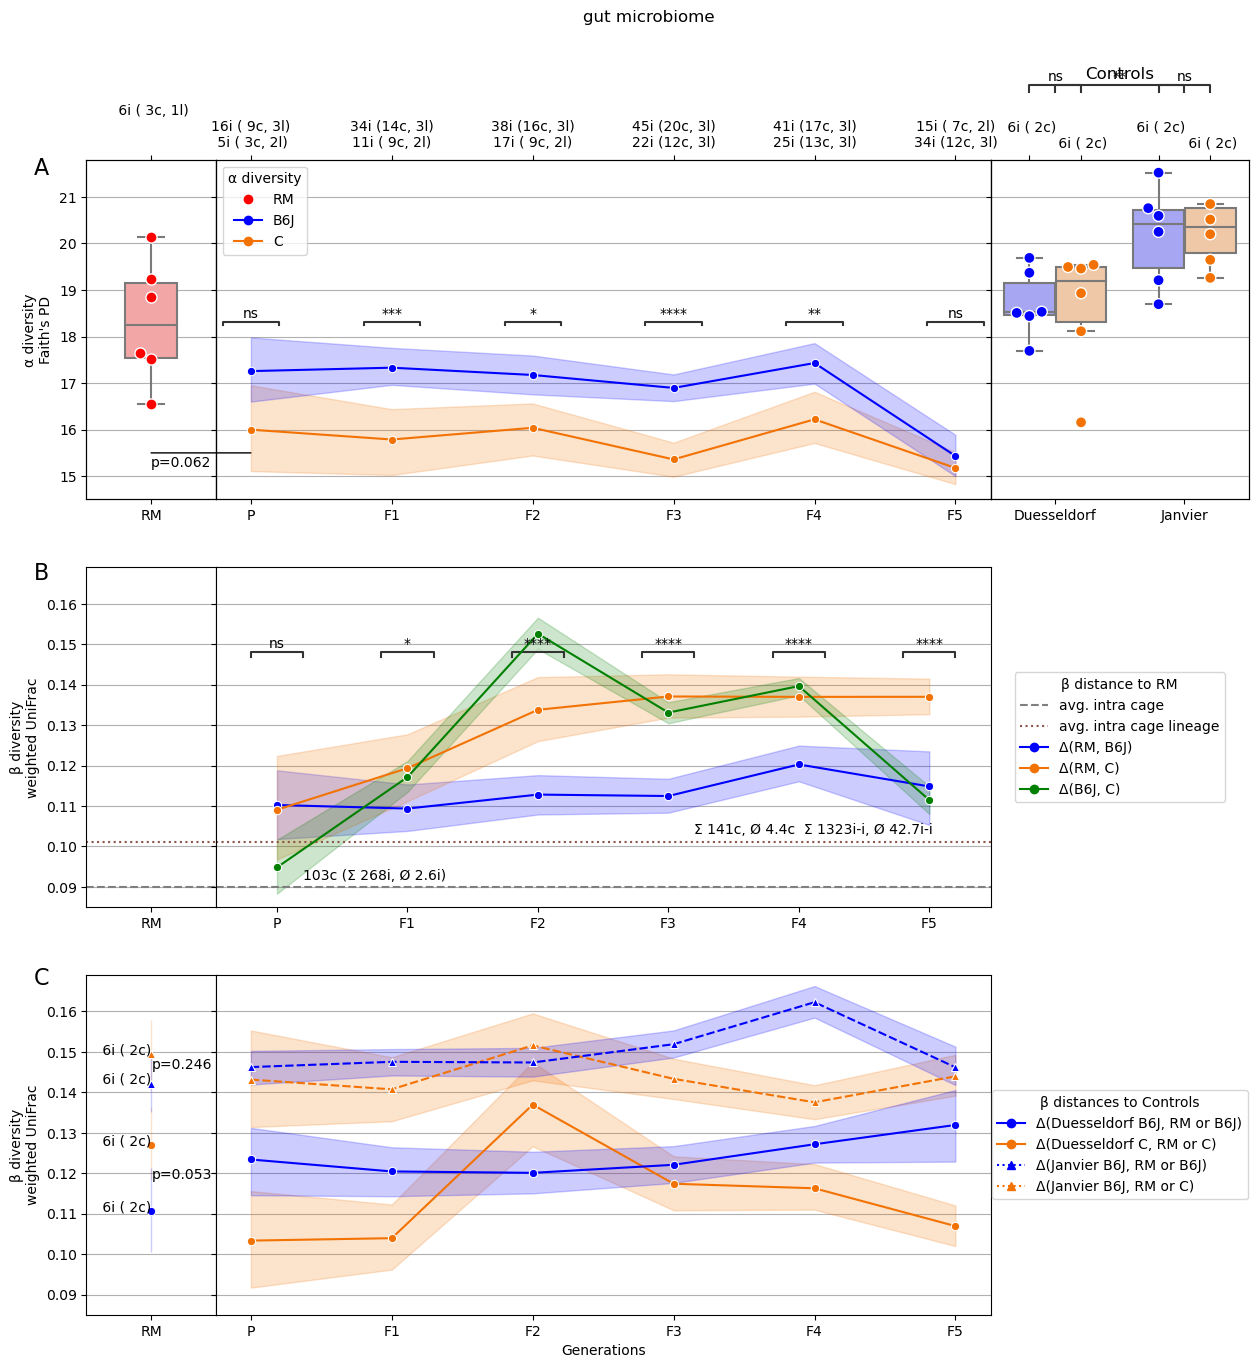

In [42]:
fig = draw_temporals(res_gut, meta_gut)

### Panel D

In [45]:
def compute_maternalLegacy(meta, res_beta, metric):
    # collect subjects that gave birth (independent of genotype, generation, cage_line)
    idx_mothers = {i for l in meta['mothers_subject_ids'].dropna().apply(lambda x: x.split('|')).values for i in l}
    #idx_mothers | = set(meta[meta['gave_birth']]['host_subject_id'].unique())
    
    dm = res_beta['results'][metric].to_data_frame()

    dists = []
    for (generation, genotype), g in meta[pd.notnull(meta['mothers_subject_ids'])].groupby(['generation', 'host_genotype']):
        idx_prevGen_mothers = set(meta[meta['host_subject_id'].isin({i for l in g['mothers_subject_ids'].apply(lambda x: x.split('|')).values for i in l})].index)

        idx_prevGen_diffGenotype_mothers = set(meta[(meta['host_subject_id'].isin(idx_mothers)) & # only mothers
                                                    (meta['generation'] == ORDER_GENERATIONS[ORDER_GENERATIONS.index(generation)-1]) & # previous generation
                                                    (meta['host_genotype'] != genotype)].index) # the other genotype
        
        d = dm.loc[list(set(dm.index) & idx_prevGen_mothers), list(set(g.index) & set(dm.index))].stack().reset_index().rename(columns={'level_0': 'idx_mother', 'level_1': 'idx_child', 0: metric})
        for f in ['cage_line', 'generation', 'host_genotype']:
            for gen in ['mother', 'child']:
                d = d.merge(meta[[f]], left_on='idx_%s' % gen, right_index=True, how='left').rename(columns={f: '%s_%s' % (f, gen)})
        d['maternal'] = d.apply(lambda x: 'true dams' if x['cage_line_mother'] == x['cage_line_child'] else 'other cage lineage', axis=1)
        dists.append(d)

        d = dm.loc[list(set(dm.index) & idx_prevGen_diffGenotype_mothers), list(set(g.index) & set(dm.index))].stack().reset_index().rename(columns={'level_0': 'idx_mother', 'level_1': 'idx_child', 0: metric})
        for f in ['cage_line', 'generation', 'host_genotype']:
            for gen in ['mother', 'child']:
                d = d.merge(meta[[f]], left_on='idx_%s' % gen, right_index=True, how='left').rename(columns={f: '%s_%s' % (f, gen)})
        d['maternal'] = 'other genotype'
        dists.append(d)

    dists = pd.concat(dists)
    dists['cat'] = dists['host_genotype_child'] + ": " + dists['generation_child']
    dists = dists.sort_values(by='cat')
    nums = dists.groupby(['generation_child','host_genotype_child','maternal']).size()
    
    return {'dists': dists, 'sample_numbers': nums}


def draw_maternalLegacy(meta, res_beta, metric='unweighted_unifrac'):
    data = compute_maternalLegacy(meta, res_beta, metric)
    dists = data['dists']
    nums = data['sample_numbers']
    
    fig, axes = plt.subplots(1, 2, figsize=(1.9*len(dists['generation_child'].unique()),5), sharey=True)
    fig.subplots_adjust(wspace=0)

    order_hue = ['true dams', 'other cage lineage', 'other genotype']

    for (ax, (host_genotype, g)) in zip(axes, list(dists.groupby('host_genotype_child'))):
        sns.boxplot(data=g, y=metric, x='generation_child', ax=ax, hue='maternal', hue_order=order_hue, palette={'other cage lineage': 'lightgray',
                                                                                                                 'other genotype': 'green',
                                                                                                                 'true dams': COLORS[host_genotype]})
        axTop = ax.twiny()
        axTop.set_xlim(ax.get_xlim())
        axTop.set_xticks(ax.get_xticks(), ['%ii-i\n%ii-i\n%ii-i' % ( 
                                               nums.loc[t.get_text(), host_genotype, 'true dams'],
                                               nums.loc[t.get_text(), host_genotype, 'other cage lineage'],
                                               nums.loc[t.get_text(), host_genotype, 'other genotype'],
                                         ) 
                                  for t in ax.get_xticklabels()])
        ax.legend().set_title("")

        annotator = Annotator(ax, 
            [((cat, 'true dams'), (cat, 'other cage lineage')) for cat in g['generation_child'].unique()] + \
            [((cat, 'other genotype'), (cat, 'other cage lineage')) for cat in g['generation_child'].unique()], 
            data=g, y=metric, x='generation_child', hue='maternal', hue_order=order_hue)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default")
        _ = annotator.apply_and_annotate()

        ax.set_xlabel("")
        if host_genotype == 'B6J':
            ax.set_ylabel('β diversity\n%s' % DM_NAMES.get(metric))
        else:
            ax.set_ylabel("")
            ax.legend().remove()
        ax.text(0, ax.get_ylim()[0]*1.2, host_genotype)
    plt.figtext(0.09, 0.89, 'D', fontsize=16)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F3_true dams vs. F3_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.439e-08 U_stat=4.859e+03
F4_true dams vs. F4_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.234e-15 U_stat=2.514e+03
F5_true dams vs. F5_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.121e-10 U_stat=3.100e+01
F2_other cage lineage vs. F2_other genotype: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.006e-28 U_stat=1.759e+03
F3_other cage lineage vs. F3_other genotype: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.139e-19 U_stat=1.213e+04
F4_other cage lineage vs. F4_other genotype: Mann-Whitney-Wilcoxon test two-sid

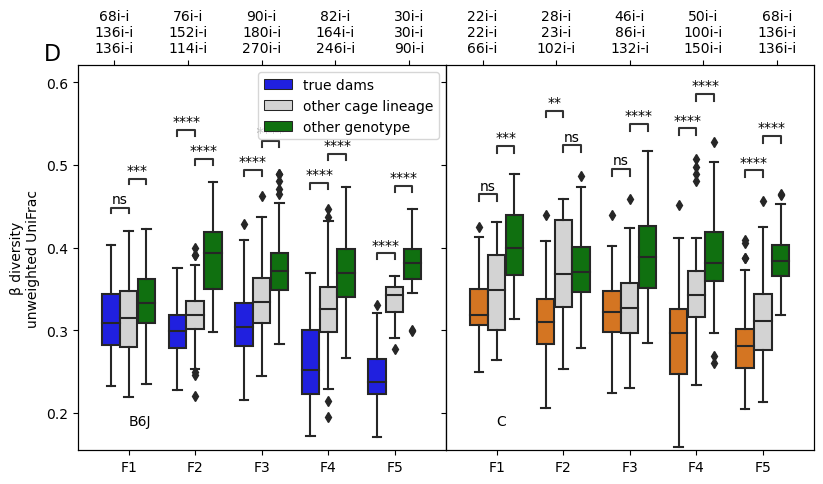

In [46]:
draw_maternalLegacy(meta_gut, res_gut['beta_diversity'], metric='unweighted_unifrac')

### Panel E

In [47]:
def compute_maternalLegacy_sourcetracker(meta, rawcounts):
    def _trueORother(row):
        if row['Source_cage_line'] == row['cage_line']:
            return 'true dams'
        # exception as C2 AND C3 in F3 where generated from C2 in F2 for C (see study design)
        if (row['generation'] == 'F3') and (row['Source_cage_line'] == 'C2') and (row['cage_line'] == 'C3'):
            return 'true dams'
        if row['Source_cage_line'] == 'Unknown':
            return 'Unknown'
        return 'other cage lineage'

    parent_child_generations = list(zip(ORDER_GENERATIONS[1:-1][:-1], ORDER_GENERATIONS[1:-1][1:]))
    res = []
    sample_numbers = dict()
    for (genP, genC) in parent_child_generations:
        meta_gen = meta[meta['generation'].isin([genP, genC])].copy()
        dams_idx = set(meta_gen[(meta_gen['host_subject_id'].isin({sid for msids in meta_gen['mothers_subject_ids'].dropna().unique() for sid in msids.split('|')})) & 
                                (meta_gen['generation'] == genP)].index)
        # anomali in B6J, generation F5: mice pair was breed, but did obtain pups
        dams_idx |= set(meta_gen[(meta_gen['generation'] == genP) & 
                                 (meta_gen['gave_birth'] == True)].index)

        meta_gen.loc[meta_gen[meta_gen['generation'] == genC].index, 'st2_type'] = "Sink"
        meta_gen.loc[list(dams_idx), 'st2_type'] = "Source"
        meta_gen = meta_gen[pd.notnull(meta_gen['st2_type'])]

        meta_gen.loc[:, 'st2_env'] = meta_gen['st2_type'].apply(lambda x: 'dam' if x == 'Source' else 'offspring') + ' : ' + meta_gen['cage_line']
        for host_genotype, g in meta_gen.groupby('host_genotype'):
            res_st2 = sourcetracker2(rawcounts, g, col_envname='st2_env', col_type='st2_type', dry=False, wait=False)        
            if res_st2['results'] is not None:
                st2 = res_st2['results'].stack().reset_index().rename(columns={0: 'impact'}).merge(meta[['cage_line']], left_on='Sink', right_index=True, how='left')
                st2['Source_cage_line'] = st2['Source'].apply(lambda x: x.split('_:_')[-1])
                st2['generation'] = genC
                st2['maternal'] = st2.apply(_trueORother, axis=1)
                st2['host_genotype'] = host_genotype
                res.append(st2)

    res = pd.concat(res)
    return res

def draw_maternalLegacy_sourcetracker(meta, rawcounts):
    res_st = compute_maternalLegacy_sourcetracker(meta, rawcounts)
    
    fig, axes = plt.subplots(1, 2, figsize=(1.05*10, 5), sharey=True)
    fig.subplots_adjust(wspace=0)

    hue_order = ['other cage lineage', 'true dams']
    numSamples = res_st[res_st['maternal'] != 'Unknown'].groupby(['host_genotype', 'generation', 'maternal']).size()

    for (ax, (host_genotype, g)) in zip(axes, res_st.groupby('host_genotype')):
        data = g[g['maternal'] != 'Unknown']
        sns.boxplot(data=data, y='impact', x='generation', hue='maternal',
                    ax=ax, palette={'true dams': COLORS[host_genotype], 'other cage lineage': 'lightgray'},
                    hue_order=hue_order)

        annotator = Annotator(ax, [
                ((generation, 'true dams'), (generation, 'other cage lineage')) for generation in g['generation'].unique()
            ], data=data, y='impact', hue='maternal', x='generation', hue_order=hue_order)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default")
        annotator.apply_and_annotate()


        if ax == axes[0]:
            ax.legend().set_title("")
        else:
            ax.legend().remove()
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.text(0, -0.205, host_genotype)

        axTop = ax.twiny()
        axTop.set_xlim(ax.get_xlim())
        axTop.set_xticks(ax.get_xticks(), 
                         ['\n'.join(['%ii' % numSamples.loc[(host_genotype, t.get_text(), maternal)]
                                     for maternal in hue_order])
                          for t in ax.get_xticklabels()])

Reduced to 50 samples (feature-table had 334, metadata had 50 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_wr24kqfs"
 Was removed.
Reduced to 16 samples (feature-table had 334, metadata had 16 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_itjeem65"
 Was removed.
Reduced to 72 samples (feature-table had 334, metadata had 72 samples)
Using existing results from '.anacache/5f64e3021946fc97ce91576ebc8459dd.sourcetracker2'. 
Reduced to 28 samples (feature-table had 334, metadata had 28 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_zrwci8sd"
 Was removed.
Reduced to 83 samples (feature-table had 334, metadata had 83 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_m_fykmh8"
 Was removed.
Reduced to 39 samples (feature-table had 334, metadata had 39 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_o0_yzq8a"
 Was removed.
Reduced to 86 samples (featur

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F2_other cage lineage vs. F2_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.909e-10 U_stat=2.011e+03
F1_other cage lineage vs. F1_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.218e-01 U_stat=1.086e+03
F3_other cage lineage vs. F3_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.577e-12 U_stat=5.250e+02
F4_other cage lineage vs. F4_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.629e-18 U_stat=5.400e+01
F5_other cage lineage vs. F5_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.469e-08 U_stat=0.000e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
   

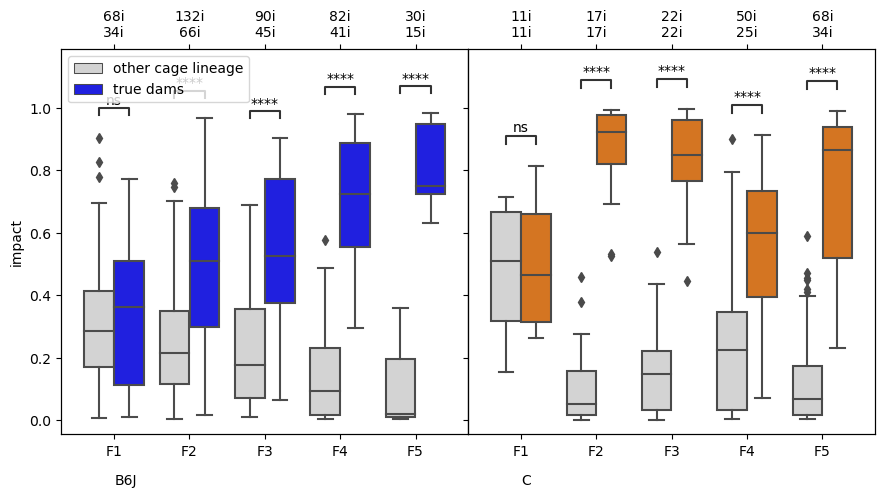

In [59]:
draw_maternalLegacy_sourcetracker(meta_gut, res_gut['counts_plantsremoved'])

### Panel F

In [49]:
meta_rob = pd.concat([meta_gut, pd.read_excel('../../Robertsen/metadata_stefan.xlsx', dtype=str, index_col=0).rename(columns={'genotype': 'host_genotype'})])
meta_rob['vendor'] = meta_rob['vendor'].replace('Jackson Laboratory', 'mJAX').replace('Taconic Farms', 'mTAC')
meta_rob

barcode center_name center_project_name concentration_ng_myl  \
13422.1     CTCTCTAT    ZETT UKD                 148                   25   
13422.10    TATCCTCT    ZETT UKD                 148                   25   
13422.100   ACTGCATA    ZETT UKD                 148                   17   
13422.101   AAGGAGTA    ZETT UKD                 148                   25   
13422.102   CTAAGCCT    ZETT UKD                 148                   22   
...              ...         ...                 ...                  ...   
ERR2784407       NaN         NaN                 NaN                  NaN   
ERR2784400       NaN         NaN                 NaN                  NaN   
ERR2784401       NaN         NaN                 NaN                  NaN   
ERR2784402       NaN         NaN                 NaN                  NaN   
ERR2784403       NaN         NaN                 NaN                  NaN   

                                experiment_design_description  \
13422.1     embryo transfer of two typical lab mice strain...   
13422.10    embryo transfer of two typical lab mice strain...   
13422.100   embryo transfer of two typical lab mice strain...   
13422.101   embryo transfer of two typical lab mice strain...   
13422.102   embryo transfer of two typical lab mice strain...   
...                                                       ...   
ERR2784407                                                NaN   
ERR2784400                                                NaN   
ERR2784401                                                NaN   
ERR2784402                                                NaN   
ERR2784403                                                NaN   

                                      flowcell i5_index i5_index_id i7_index  \
13422.1     200721_M04304_0230_000000000-J7F5M   S502-A    CTCTCTAT   N701-A   
13422.10    200721_M04304_0230_000000000-J7F5M   S503-A    TATCCTCT   N702-A   
13422.100   200721_M04304_0230_000000000-J7F5M   S506-B    ACTGCATA   N716-B   
13422.101   200721_M04304_0230_000000000-J7F5M   S507-B    AAGGAGTA   N716-B   
13422.102   200721_M04304_0230_000000000-J7F5M   S508-B    CTAAGCCT   N716-B   
...                                        ...      ...         ...      ...   
ERR2784407                                 NaN      NaN         NaN      NaN   
ERR2784400                                 NaN      NaN         NaN      NaN   
ERR2784401                                 NaN      NaN         NaN      NaN   
ERR2784402                                 NaN      NaN         NaN      NaN   
ERR2784403                                 NaN      NaN         NaN      NaN   

           i7_index_id  ... vendor skipped_samples breeding_pair litter  \
13422.1       TAAGGCGA  ...    NaN             NaN           NaN    NaN   
13422.10      CGTACTAG  ...    NaN             NaN           NaN    NaN   
13422.100     ACTCGCTA  ...    NaN             NaN           NaN    NaN   
13422.101     ACTCGCTA  ...    NaN             NaN           NaN    NaN   
13422.102     ACTCGCTA  ...    NaN             NaN           NaN    NaN   
...                ...  ...    ...             ...           ...    ...   
ERR2784407         NaN  ...   mJAX             NaN           NaN    NaN   
ERR2784400         NaN  ...   mTAC             NaN           NaN    NaN   
ERR2784401         NaN  ...   mTAC             NaN           NaN    NaN   
ERR2784402         NaN  ...   mTAC             NaN           NaN    NaN   
ERR2784403         NaN  ...   mTAC             NaN           NaN    NaN   

           instrument_platform             illumina_runid num_reads  \
13422.1                    NaN                        NaN       NaN   
13422.10                   NaN                        NaN       NaN   
13422.100                  NaN                        NaN       NaN   
13422.101                  NaN                        NaN       NaN   
13422.102                  NaN                        NaN       NaN   
...                

In [50]:
# merge feature table
fp_counts_both = 'tmp_dir/counts_both.biom'
os.makedirs(os.path.dirname(fp_counts_both), exist_ok=True)
#TODO explain how robertson deblur table was created
pandas2biom(fp_counts_both, pd.concat([
    res_gut['counts_plantsremoved'].loc[:, meta_gut.index],
    biom2pandas("../../Robertsen/no_backup/deblur/deblur_res/reference-hit.biom")], axis=1).fillna(0))

In [51]:
# construct shared insertion tree
seppres = project_sepp({'paths': {'deblur_table': fp_counts_both,
                                  'tmp_workdir': 'tmp_dir/'}})

Using existing results from '.anacache/e29beb81fd9d748d0c50c2481747984b.sepp'. 


SEPP version number: 2023.5.0, 4.3.10


loading tree. Be patient. Can take up around 8 minutes.


Information: 1 of 2129 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/191d163193d64b4ce396cde963cbfaa8.taxRDP'. 
Using existing results from '.anacache/310dc3ca791d70cc483641bfb53ed789.rare'. 
Using existing results from '.anacache/1c69ddaf05dcef2b2fd4198c76280f8d.rarefy'. 
Using existing results from '.anacache/12930168d000c02c332576d38c7ee48c.adiv'. 
Using existing results from '.anacache/bee97e95cf026b29ba57df035d65876f.bdiv'. 
Working directory is '/homes/sjanssen/TMP/ana_emperor_jdkyvpep', cachefile is '.anacache/926baaf6c360cdc3bcf09749c26b5dc0.emperor'. Info: reducing number of samples for Emperor plot to 677
Now wait until 21308612 job finishes.
Your final feature table is composed of 747 samples and 2820 features.


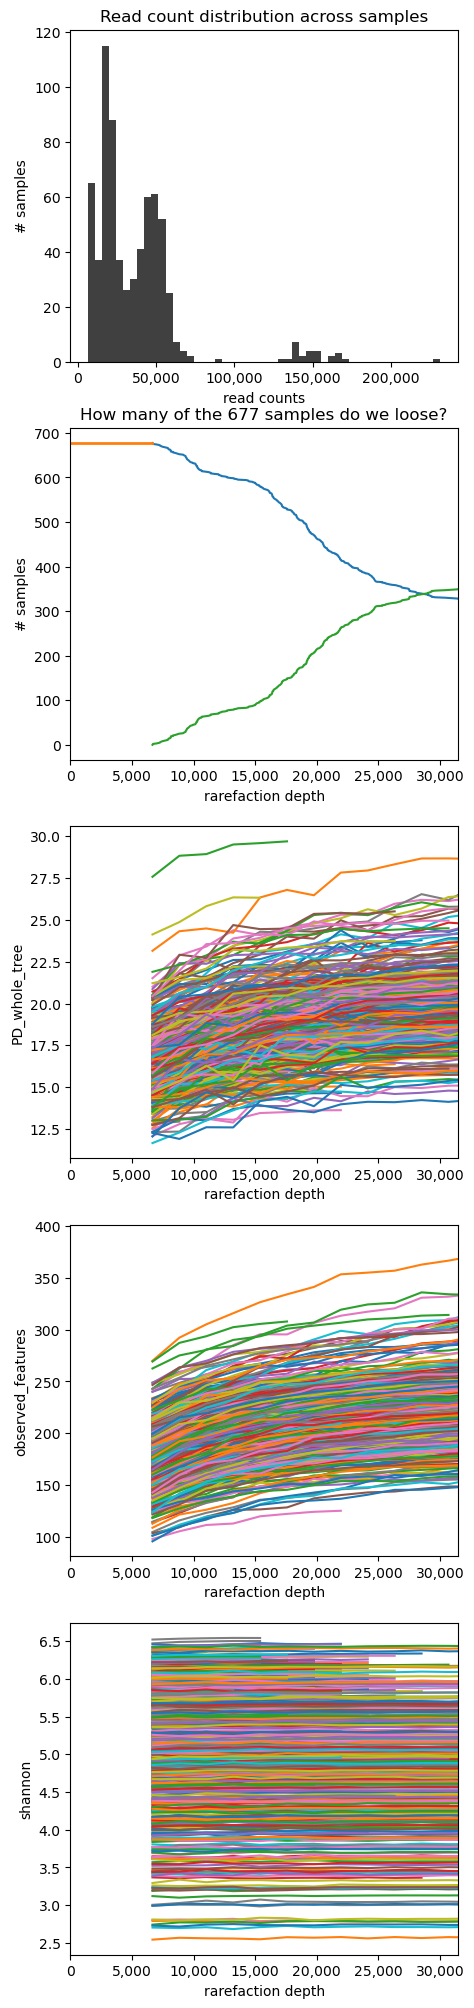

In [52]:
idx_control_samples = set(meta_rob[meta_rob['sample_type'].isin(['sterile water', 'control bedding', 'control food'])].index)
res_rob = process_study(
    metadata=meta_rob,
    control_samples=idx_control_samples,
    fp_deblur_biom=fp_counts_both,
    fp_insertiontree=seppres['paths']['insertion_tree'],
    rarefaction_depth=6000,
    fp_taxonomy_trained_classifier="/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg_2022_10_backbone_full_length.nb_2023.5.qza",
    tree_insert=seppres['insertion_tree'],
    is_v4_region=False,
    emperor_fp='Generated/Emperor',
    emperor_infix='_robertson',
    dry=False,
    use_grid=True, 
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    emperor_skip_tsne_umap=True,
)

In [53]:
dists = []
metric = 'unweighted_unifrac'
dm = res_rob['beta_diversity']['results'][metric].to_data_frame()
for (genotype_benga, generation_benga), g_benga in meta_rob[
                                       (meta_rob['host_scientific_name'] == "mus musculus") & 
                                       (meta_rob['sample_type'] == "colon content") & 
                                       (meta_rob['host_body_site'] == "uberon:colon") & 
                                       (meta_rob['qiita_study_id'] != 'Robertsen')].fillna({'generation': 'control'}).groupby(['host_genotype', 'generation']):
    if genotype_benga == "b6cf1":
        continue
    for (genotype_rob, generation_rob, vendor_rob, experiment_rob, sample_title_rob), g_rob in meta_rob[
                                       (meta_rob['host_scientific_name'] == "mus musculus") & 
                                       (meta_rob['sample_type'] == "colon content") & 
                                       (meta_rob['host_body_site'] == "uberon:colon") & 
                                       (meta_rob['qiita_study_id'] == 'Robertsen') & 
                                       (pd.isnull(meta_rob["skipped_samples"]))].fillna({'sample_title':'?'}).groupby(['host_genotype', 'generation','vendor','experiment', 'sample_title']):
        #print(genotype_benga, generation_benga, g_benga.shape[0], genotype_rob, generation_rob, vendor_rob, experiment_rob, g_rob.shape[0])
        dm_sub = dm.loc[list(set(g_benga.index) & set(dm.index)),
                        list(set(g_rob.index)   & set(dm.index))]
        dm_sub = dm_sub.stack().reset_index()
        dm_sub['host_genotype_benga'] = genotype_benga
        dm_sub['generation_benga'] = generation_benga
        dm_sub['generation_rob'] = generation_rob
        dm_sub['vendor_rob'] = vendor_rob
        dm_sub['experiment_rob'] = experiment_rob
        dm_sub['sample_title'] = sample_title_rob
        dists.append(dm_sub)
dists = pd.concat(dists)

In [54]:
nums = dict()
d1 = dists[dists['experiment_rob'].isin(['littermates','sentinels'])].copy()
d1['cat'] = 'host_genotype : ' + d1['host_genotype_benga'] + " VS " + d1.apply(lambda row: 'both' if row['host_genotype_benga'] == 'C' else row['vendor_rob'], axis=1)

d2 = dists[dists['experiment_rob'].isin(['littermates']) &
           (dists['host_genotype_benga'] == 'B6J') & 
           (dists['generation_rob'] == 'f2')].copy()
d2['cat'] = 'maternal legacy : ' + d2['vendor_rob']

d3 = dists[dists['experiment_rob'].isin(['littermates','sentinels']) &
           (dists['host_genotype_benga'] == 'B6J') & 
           (dists['vendor_rob'] == 'mJAX')].copy()
d3['cat'] = 'generation : ' + d3['generation_rob']

d4 = dists[dists['experiment_rob'].isin(['littermates','sentinels']) &
           (dists['host_genotype_benga'] == 'B6J') & 
           (dists['vendor_rob'] == 'mJAX') & 
           (dists['generation_rob'] == 'f2')].copy()
d4['cat'] = 'breeding : ' + d4['generation_benga']

d5 = dists[(dists['experiment_rob'] == 'co-housing') & 
           (dists['host_genotype_benga'] == 'B6J')].copy()
d5['cat'] = 'co-housing : ' + d5['sample_title']

comb_dists = pd.concat([d1, d2, d3, d4],axis=0)
comb_dists = comb_dists.rename(columns={0: metric})

nums = dict()
for c, g in comb_dists.groupby('cat'):
    nums[c] = pd.concat([meta_rob.loc[g['level_0'].unique(),:].groupby('host_genotype').size(),
                         meta_rob.loc[g['level_1'].unique(),:].groupby('vendor').size()])
# nums

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

host_genotype : B6J VS mTAC vs. host_genotype : B6J VS mJAX: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.034e-168 U_stat=1.991e+07
host_genotype : C VS both vs. host_genotype : B6J VS mTAC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.122e-215 U_stat=2.583e+07
generation : f1 vs. generation : f2: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.618e-144 U_stat=3.530e+06
generation : p1 vs. generation : f1: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.405e-34 U_stat=1.553e+06
generation : f2 vs. maternal legacy : mTAC: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.622e-97 U_stat=8.512e+05
breeding : P vs. breeding : F1: Mann-Whitney-Wil

Text(0.09, 0.89, 'F')

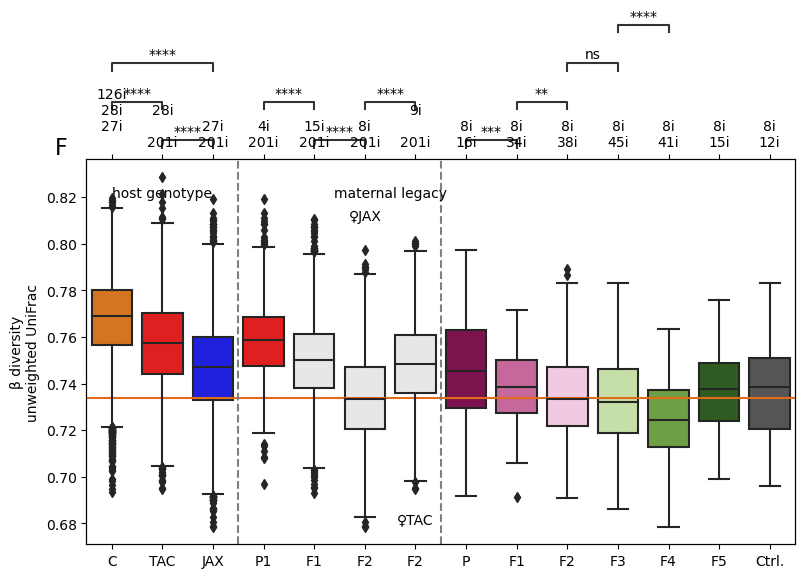

In [55]:
fig, axes = plt.subplots(1,1, figsize=(8/14*16,5)) #(8,5)

o_cat = [
    'host_genotype : C VS both', 'host_genotype : B6J VS mTAC', 'host_genotype : B6J VS mJAX',
    'generation : p1', 'generation : f1', 'generation : f2',
    'maternal legacy : mTAC', 
    'breeding : P', 'breeding : F1', 'breeding : F2', 'breeding : F3', 'breeding : F4', 'breeding : F5','breeding : control', 
]
pal = {
    'host_genotype : C VS both': COLORS['C'],
    'host_genotype : B6J VS mJAX': COLORS['B6J'],
    'host_genotype : B6J VS mTAC': COLORS['mJAX'],
    
    'generation : p1': COLORS['mJAX'], 
    'generation : f1': '#e7e7e7', 
    'generation : f2': '#e7e7e7',
    'maternal legacy : mTAC': '#e7e7e7',
    
    'breeding : P': COLORS['P'], 
    'breeding : F1': COLORS['F1'], 
    'breeding : F2': COLORS['F2'], 
    'breeding : F3': COLORS['F3'], 
    'breeding : F4': COLORS['F4'], 
    'breeding : F5': COLORS['F5'],
    'breeding : control': '#555555',
}

sns.boxplot(data=comb_dists, y=metric, x='cat', ax=axes, zorder=10, 
            order=o_cat, palette=pal,
           )
axes.axhline(y=comb_dists.groupby('cat').mean(numeric_only=True).loc['generation : f2',metric], color='#e16d1a')
axes.axvline(x=2.5, color='gray', linestyle='--')
axes.axvline(x=6.5, color='gray', linestyle='--')
axes.set_ylabel('β diversity\n%s' % DM_NAMES.get(metric))

axTop = axes.twiny()
axTop.set_xlim(axes.get_xlim())
axTop.set_xticks(axes.get_xticks(), 
                 ['\n'.join(['' if (nums[t.get_text()].to_dict().get(hg, 0) == 0) else '%ii' % nums[t.get_text()].to_dict().get(hg, 0)
                  for hg in ['C', 'mTAC', 'mJAX', 'B6J']])
                  for t in axes.get_xticklabels()])
axes.set_xticklabels(['C', 'TAC', 'JAX', 
                      'P1', 'F1', 'F2', 'F2',
                      'P', 'F1', 'F2', 'F3', 'F4', 'F5', 'Ctrl.'])
axes.set_xlabel("")

annotator = Annotator(axes, [
    ('host_genotype : B6J VS mTAC', 'host_genotype : B6J VS mJAX'),
    ('host_genotype : C VS both', 'host_genotype : B6J VS mTAC'),
    ('host_genotype : C VS both', 'host_genotype : B6J VS mJAX'),

    ('generation : f1', 'generation : f2'),
    ('generation : p1', 'generation : f1'),

    ('maternal legacy : mTAC', 'generation : f2'),

    ('breeding : P', 'breeding : F1'),
    ('breeding : F1', 'breeding : F2'),
    ('breeding : F2', 'breeding : F3'),
    ('breeding : F3', 'breeding : F4'),

], data=comb_dists, y=metric, x='cat', order=o_cat)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default")
annotator.apply_and_annotate()

axes.text(1, 0.82, 'host genotype', horizontalalignment='center')
axes.text(5.5, 0.82, 'maternal legacy', horizontalalignment='center')
axes.text(5, 0.81, '♀JAX', horizontalalignment='center')
axes.text(6, 0.68, '♀TAC', horizontalalignment='center')

plt.figtext(0.09, 0.89, 'F', fontsize=16)

## Figure 4
### Panels A,B,C

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F1_B6J vs. F1_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.766e-02 U_stat=1.700e+01
P_B6J vs. P_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.372e-01 U_stat=4.100e+01
F2_B6J vs. F2_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.592e-01 U_stat=1.200e+02
F3_B6J vs. F3_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.115e-01 U_stat=3.460e+02
F4_B6J vs. F4_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.282e-01 U_stat=4.240e+02
F5_B6J vs. F5_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.899e-01 U_stat=2.110e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-

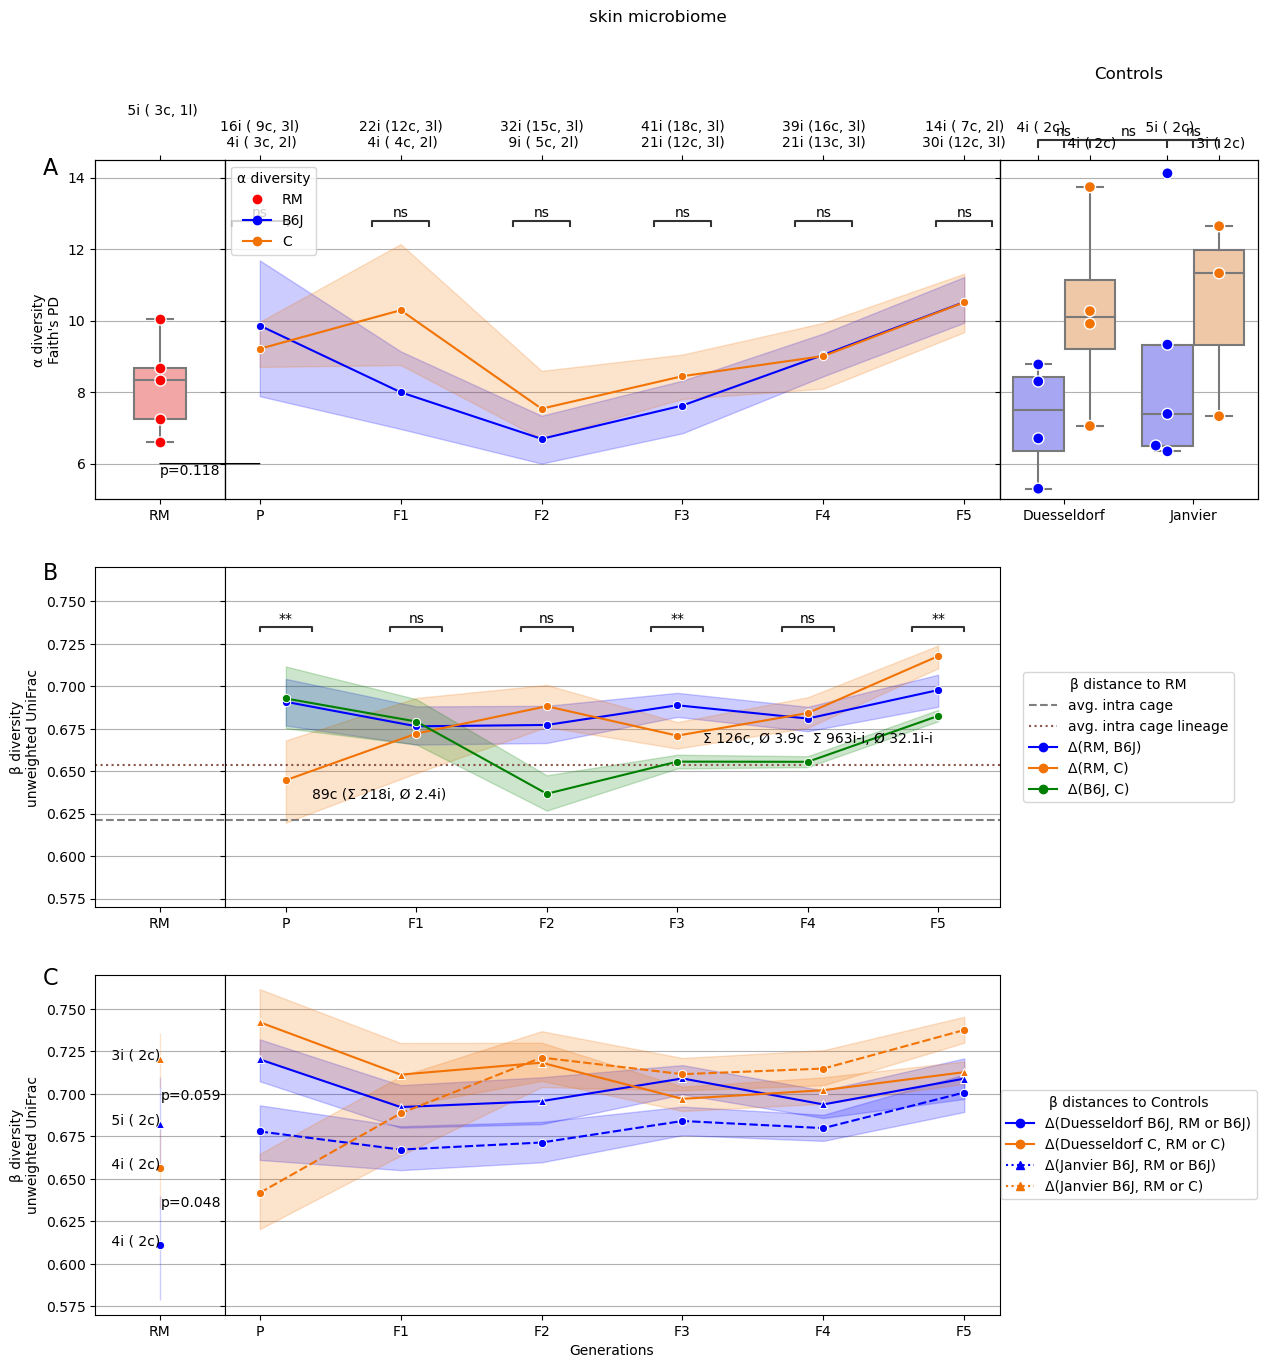

In [56]:
fig = draw_temporals(res_skin, meta_skin, 
                     ALPHA_LIM=(5,14.5),
                     METRIC_BETA='unweighted_unifrac', BETA_LIM=(0.57, 0.77),
                     title='skin microbiome')

### Panel D

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F3_true dams vs. F3_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.611e-01 U_stat=6.243e+03
F4_true dams vs. F4_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.014e-01 U_stat=5.579e+03
F5_true dams vs. F5_other cage lineage: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.763e-01 U_stat=3.820e+02
F2_other cage lineage vs. F2_other genotype: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.612e-12 U_stat=3.480e+02
F3_other cage lineage vs. F3_other genotype: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.344e-02 U_stat=1.494e+04
F4_other cage lineage vs. F4_other genotype: Mann-Whitney-Wilcoxon test two-sid

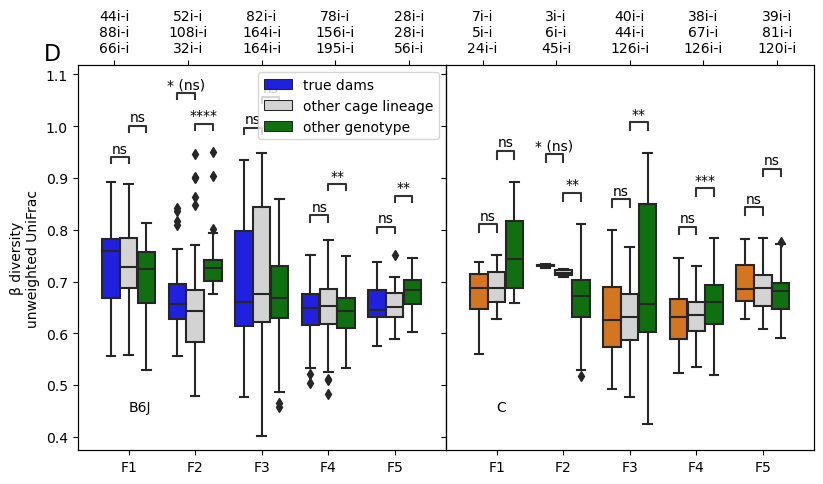

In [57]:
draw_maternalLegacy(meta_skin, res_skin['beta_diversity'], metric='unweighted_unifrac')

### Panel E

Reduced to 38 samples (feature-table had 334, metadata had 38 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_et2haut5"
 Was removed.
Reduced to 8 samples (feature-table had 334, metadata had 8 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_fh8cd4ms"
 Was removed.
Reduced to 54 samples (feature-table had 334, metadata had 54 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_bxtiyafg"
 Was removed.
Reduced to 13 samples (feature-table had 334, metadata had 13 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2__3zx44mg"
 Was removed.
Reduced to 73 samples (feature-table had 334, metadata had 73 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2__0cadh0q"
 Was removed.
Reduced to 30 samples (feature-table had 334, metadata had 30 samples)
found matching working dir "/homes/sjanssen/TMP/ana_sourcetracker2_d7oaf4ct"
 Was removed.
Reduced to 80 samples (feature

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

F2_other cage lineage vs. F2_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.652e-01 U_stat=9.070e+02
F1_other cage lineage vs. F1_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.908e-01 U_stat=4.640e+02
F3_other cage lineage vs. F3_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.510e-01 U_stat=1.540e+03
F4_other cage lineage vs. F4_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.970e-01 U_stat=1.566e+03
F5_other cage lineage vs. F5_true dams: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.539e-02 U_stat=2.590e+02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
   

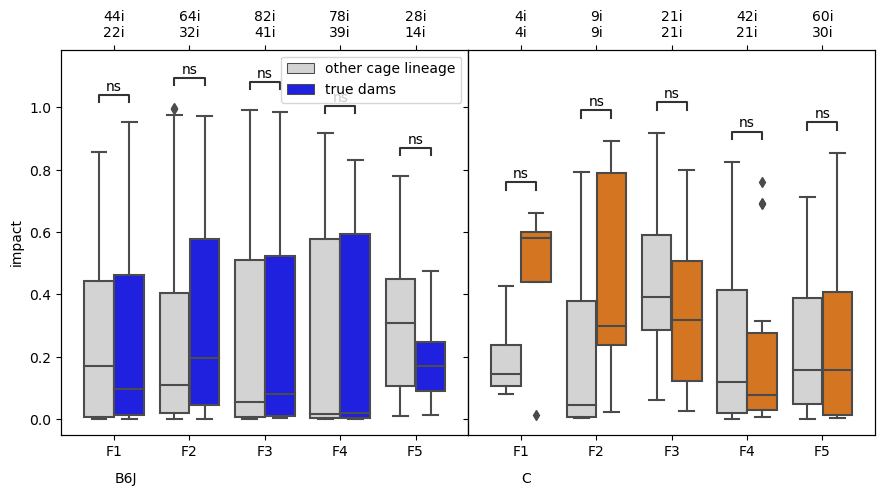

In [60]:
draw_maternalLegacy_sourcetracker(meta_skin, res_skin['counts_plantsremoved'])

## Figure 5
### Panel A

In [61]:
def drawTaxBarplot(res, meta, title='gut microbiome', minreadnr=60*270*0.5):
    fig, axes = plt.subplots(3,1,figsize=(40,5+2), gridspec_kw={'height_ratios': [10, 0.5, 0.5]})
    tax = plotTaxonomy(res['rarefaction']['results'], 
                       meta.fillna('Controls').sort_values(by='generation_cageline', key=KEY_TAXPLOT),
                       file_taxonomy=res['taxonomy']['RDP']['results']['Taxon'],
                       group_l1='sample_category', 
                       group_l2='generation_cageline', 
                       rank='Genus',
                       min_abundance_grayscale=0.0, grayscale=True,
                       no_top_labels=True, no_sample_numbers=True,
                       print_meanrelabunances=True, 
                       minreadnr=minreadnr, 
                       ax=axes[0], horizontal_spacer=3)

    for ax in axes[1:]:
        ax.set_xlim(axes[0].get_xlim())
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_ylim((0,1))
        ax.set_facecolor("white")

    for _, row in tax[2].iterrows():
        axes[1].add_patch(Rectangle((row['xpos'], 0), 1, 1, linewidth=None, color=COLORS.get(row['group_l2'].split('_')[0], 'white')))
        axes[2].add_patch(Rectangle((row['xpos'], 0), 1, 1, linewidth=None, color=COLORS.get(row['group_l2'].split('_')[-1], 'white')))

    for (field, pos, ax) in [('generation', 0, axes[1]), ('cage_line', -1, axes[2])]:
        tax[2][field] = tax[2]['group_l2'].apply(lambda x: x.split('_')[pos])
        tax[2]['run_%s' % field] = tax[2].ne(tax[2].shift()).cumsum()[field]
        for run, g in tax[2].groupby('run_%s' % field, sort=False):
            text = g[field].unique()[0]
            if g['group_l2'].unique()[0] != text:
                ax.text(g['xpos'].mean(), 0.2, text, horizontalalignment='center')   
    fig.suptitle(title)

129 taxa left after collapsing to Genus.
333 samples left with metadata and counts.
raw counts: 333
raw meta: 333
meta with counts: 333 samples x 94 fields
counts with meta: 333
saved plotting 0 boxes.


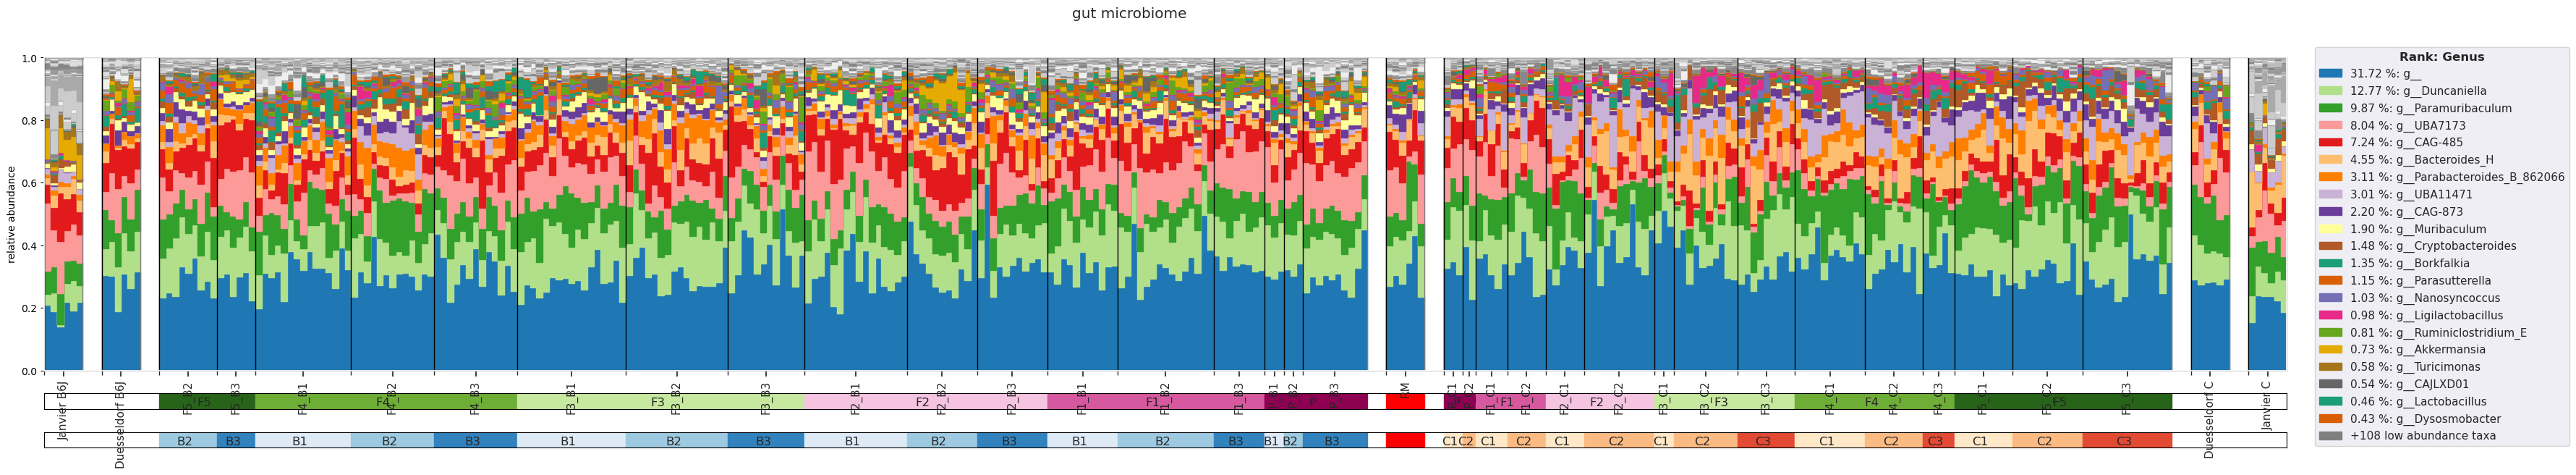

In [62]:
drawTaxBarplot(res_gut, meta_gut)

### Panel B: <span style="color:red">Anna</span>
### Panel C: <span style="color:red">Anna</span>
### Panel D: <span style="color:red">Anna</span>


## Figure 6
### Panel A <span style="color:red">??????</span>

it is unclear to my, why Anna's version has a independent_cage_lineage with p < 0.05, but not my version?!?
Is this due to different beta distance matrices, due to rarefaction OR differently labeles / selected samples?

In [238]:
helper = pickle.load(open('../../Anna/Notebook/.anacache/7d21b6434724676190c537f4b0c09518.bdiv', 'rb'))['results']

Using existing results from '.anacache/890a215a50ee15ffb741c5f807479d6e.fRDAbeta'. 


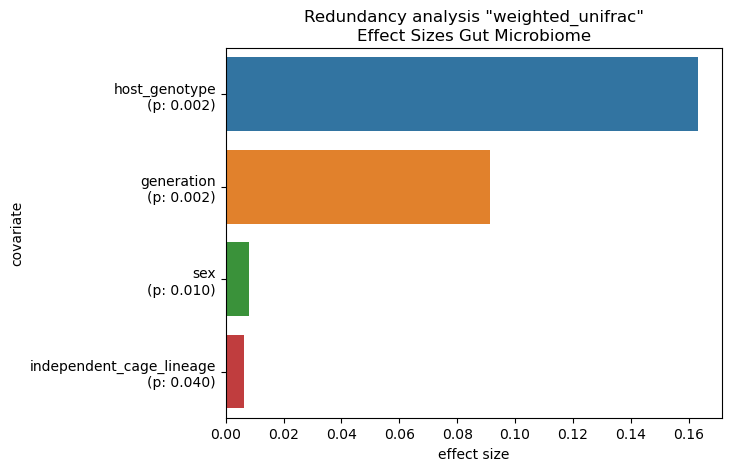

In [239]:
res_red = redundancy_analysis_beta(meta_gut, helper['weighted_unifrac'], 'weighted_unifrac',
                                   categorials=['host_genotype','independent_cage_lineage','sex',], intervals=[], dates={},
                                   ordinals={'generation': ['P1', 'F1', 'F2', 'F3', 'F4', 'F5']},
                                   title='Effect Sizes Gut Microbiome',
                                   dry=False, wait=False, use_grid=True, dirty=True)

found matching working dir "/homes/sjanssen/TMP/ana_fRDAbeta_lkvum1qx"


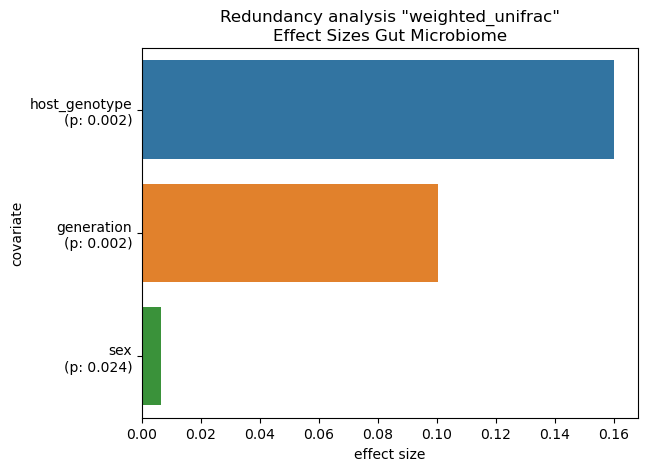

In [241]:
res_red = redundancy_analysis_beta(meta_gut[pd.notnull(meta_gut['generation'])], 
                                   res_gut['beta_diversity']['results']['weighted_unifrac'], 
                                   #helper['weighted_unifrac'],
                                   'weighted_unifrac',
                                   categorials=['host_genotype','independent_cage_lineage','sex',], intervals=[], dates={},
                                   ordinals={'generation': ['P', 'F1', 'F2', 'F3', 'F4', 'F5']},
                                   title='Effect Sizes Gut Microbiome',
                                   dry=False, wait=False, use_grid=True, dirty=True)

## Figure 7

In [63]:
fp_metabolites = 'Incoming/220511__Data_21-0025.xlsx'
x = pd.read_excel(fp_metabolites, sheet_name="01.AllData").rename(columns={'Sample.label.on.tube': 'sample_name'})
x['sample_name'] = 'sample.' + x['sample_name'].astype(str)
data = x[['sample_name', "ISTD", "Resp", "ISTD.Resp", "Resp.Ratio", "UserAnno.Peak", "MI.Peak", "MZ", "MZ.Ex.Left", "MZ.Ex.Right", "MZ.Ex.Units", "RT.Compound", "RT.Peak", "MS.Replicates", "data.source", "ISTD.Resp.Ratio", "Acq.Method.Condensed", "MS.project", "Report.Name", "data.dir", "relativeResponse", "IQR_1.5_outlier", "Compound"]].set_index(['sample_name', 'Compound'])
counts_chems = pd.pivot_table(data=data, columns='sample_name', index="Compound", values="relativeResponse").fillna(0)
# remove compounds containing 'unknown' in its name
counts_chems = counts_chems.loc[[c for c in counts_chems.index if 'unknown' not in c], :]

# also load metadata from Excel sheet that Philipp Westhoff provided
meta_chems = x[['sample_name', "date", "MS.Label", "Species", "Tissue.type", "Condition.1", "Generation", "Benga-Nr."]].set_index(['sample_name']).drop_duplicates().rename(columns={'Condition.1': 'genotype', 'Generation': 'generation'})
meta_chems['Benga-Nr.'] = meta_chems['Benga-Nr.'].astype(str)

# merge metadata from Philipp and Qiita
meta_chems = meta_chems.reset_index().merge(metadata.groupby('host_subject_id_bmfz').head(1), left_on='Benga-Nr.', right_on='host_subject_id_bmfz', how='left').set_index('sample_name')

res_beta_chems = beta_diversity(counts_chems, metrics=['bray_curtis'], dry=False, wait=False)
if res_beta_chems['results'] is not None:
    res_emp_chems = emperor(meta_chems, res_beta_chems['results'], fp_results='Generated/Emperor/', infix='_metabolites', run_tsne_umap=False, dry=False, wait=False)

Using existing results from '.anacache/380cb3bee3ce79e527beef31ca437a15.bdiv'. 
Working directory is '/homes/sjanssen/TMP/ana_emperor_tkoq14_e', cachefile is '.anacache/2468971b1b06a71d95a2e0ee5c9fcdb7.emperor'. Now wait until 21311666 job finishes.


### Panel A
Use `Generated/Emperor/emperor-pcoa_metabolites_bray_curtis` to upload to `view.qiime2.org`

### Panel A
see Figure 2, but load settings from file `EmperorSettings/emp_settings_metabolites.json`
![image.png](attachment:image.png)


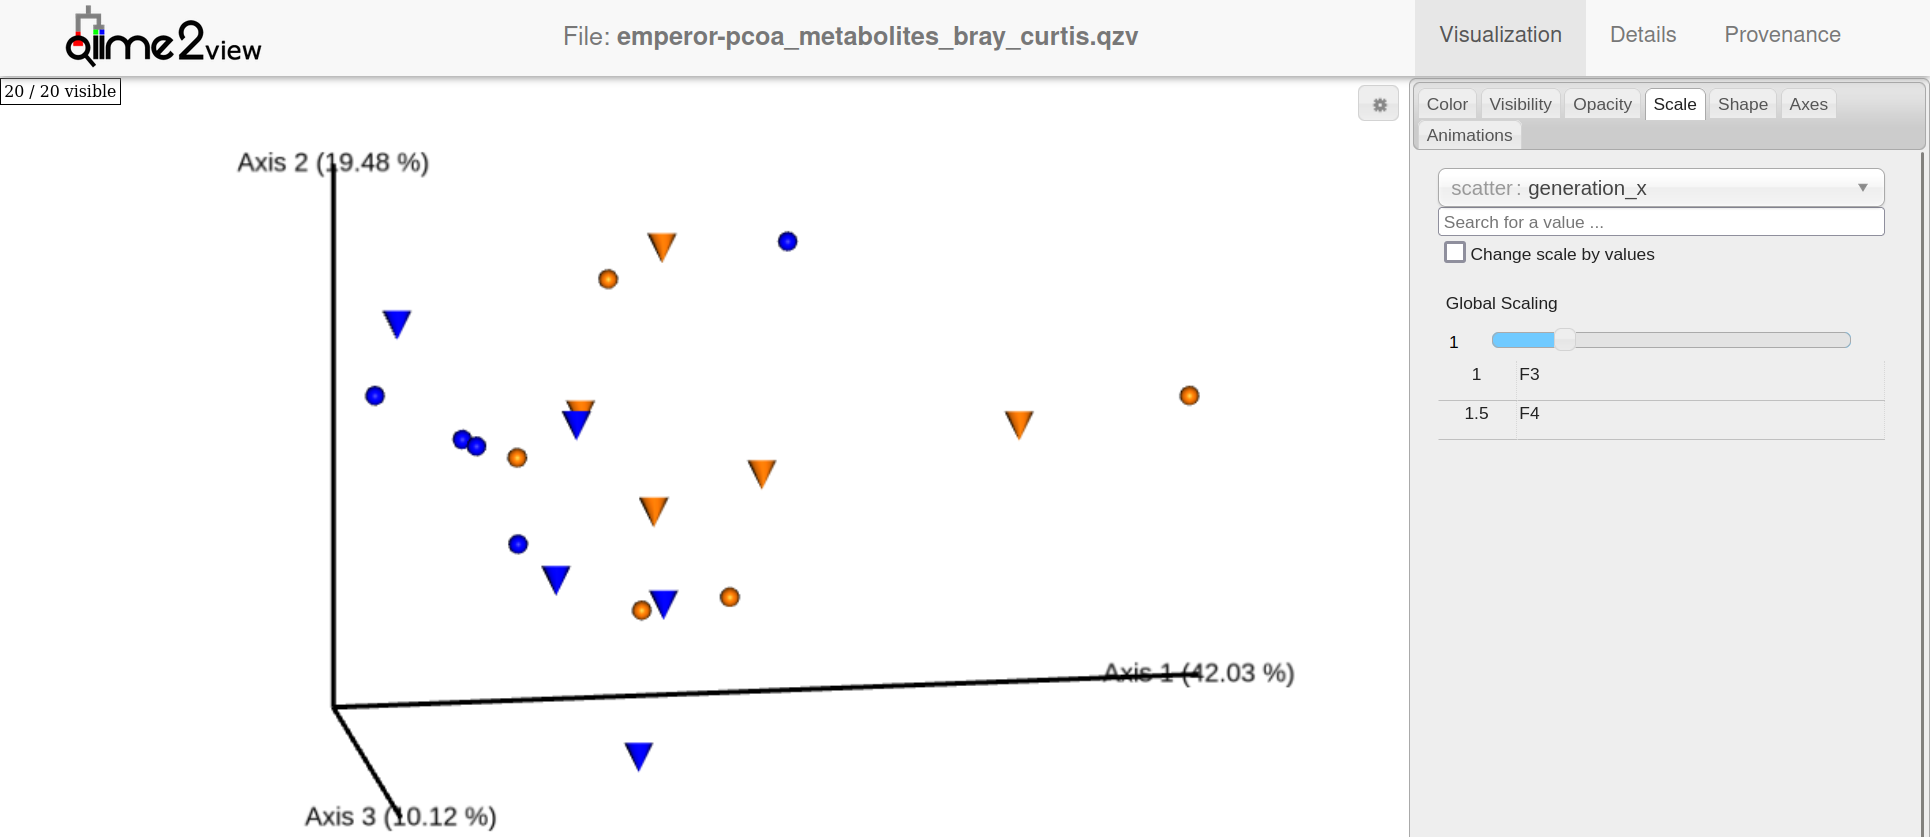

### Panel B

/homes/sjanssen/Git/sjanssen2/ggmap/ggmap/snippets.py:1868: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  in groupings.value_counts().iteritems()


Text(0.09, 0.89, 'B')

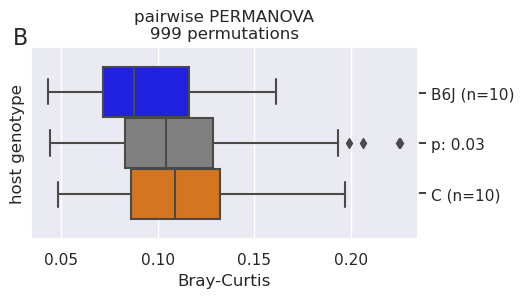

In [64]:
dm = res_beta_chems['results']['bray_curtis']
metacol = meta_chems['host_genotype']
fig, axes = plt.subplots(figsize=(5,2.5))
testres = detect_distant_groups(dm, 'Bray-Curtis', metacol)
p = plotGroup_permanovas(dm, metacol, **testres, 
                         ax=axes, horizontal=True, colors_boxplot={'left': COLORS['B6J'],
                                                                   'right': COLORS['C'],
                                                                   'between': 'gray'})
axes.set_ylabel('host genotype')
axes.yaxis.label.set_visible(True)
axes.set_title('pairwise PERMANOVA\n999 permutations')
offset = 0.26
_ = axes.set_yticks([-1*offset,0,offset], ['B6J (n=%i)' % meta_chems['host_genotype'].value_counts().loc['B6J'], 
                                           'p: %.2f' % testres['network']['B6J']['C']['p-value'], 
                                           'C (n=%i)' % meta_chems['host_genotype'].value_counts().loc['C']])
plt.figtext(0.09, 0.89, 'B', fontsize=16)

### Panel C

/homes/sjanssen/Git/sjanssen2/ggmap/ggmap/snippets.py:1868: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  in groupings.value_counts().iteritems()


Text(0.09, 0.89, 'C')

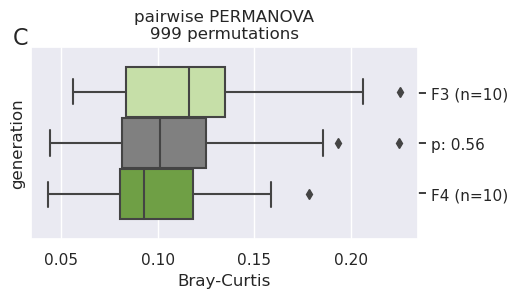

In [65]:
metacol = meta_chems['generation_y']
fig, axes = plt.subplots(figsize=(5,2.5))
testres = detect_distant_groups(dm, 'Bray-Curtis', metacol)
p = plotGroup_permanovas(dm, metacol, **testres, 
                         ax=axes, horizontal=True, colors_boxplot={'left': COLORS['F3'],
                                                                   'right': COLORS['F4'],
                                                                   'between': 'gray'})
axes.set_ylabel('generation')
axes.yaxis.label.set_visible(True)
axes.set_title('pairwise PERMANOVA\n999 permutations')
offset = 0.26
_ = axes.set_yticks([-1*offset,0,offset], ['F3 (n=%i)' % meta_chems['generation_x'].value_counts().loc['F3'], 
                                           'p: %.2f' % testres['network']['F3']['F4']['p-value'], 
                                           'F4 (n=%i)' % meta_chems['generation_x'].value_counts().loc['F4']])
plt.figtext(0.09, 0.89, 'C', fontsize=16)

### Panel D

/homes/sjanssen/Git/sjanssen2/ggmap/ggmap/snippets.py:2385: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  metadata = metadata.loc[set(calour_experiment.sample_metadata.index) & set(metadata.index), :]
/homes/sjanssen/Git/sjanssen2/ggmap/ggmap/snippets.py:2320: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  metadata = metadata.loc[set(calour_experiment.sample_metadata.index) & set(metadata.index), :]


'host_genotype'  (n=10)
     6 (of   41) taxa different between 'B6J' (n=5) vs. 'C' (n=5)



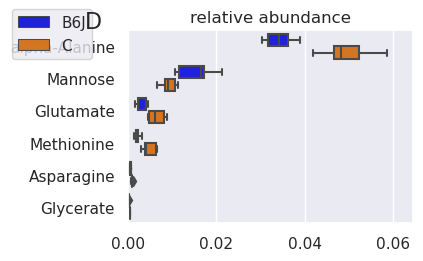

In [69]:
dsFDR_experiment = dict()
# for dsFDR
pandas2biom('tmp_dir/tmp_dsfrd_metabolome.biom', counts_chems)
meta_chems.to_csv('tmp_dir/tmp_dsfdr_metabolome_meta.tsv', sep="\t", index=True)

dsFDR_experiment = ca.read_amplicon('tmp_dir/tmp_dsfrd_metabolome.biom', 
                                    'tmp_dir/tmp_dsfdr_metabolome_meta.tsv', min_reads=0, normalize=10000)

field = 'host_genotype'
res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, meta_chems[meta_chems['generation_x'] == 'F4'], [field],
                                    random_seed=42)

if len(res_dsFDR_genotype) > 0:
    p = plot_diff_taxa(counts_chems, meta_chems[meta_chems['generation_x'] == 'F4'][field], res_dsFDR_genotype,
                       min_mean_abundance=0.0,
                       colors_boxplot=COLORS, 
                       color_barplot='gray'
                      )
    p[0].get_axes()[0].set_ylabel("compound")
    
    p[0].delaxes(p[0].get_axes()[2])
    p[0].delaxes(p[0].get_axes()[1])
    
    p[0].get_axes()[0].set_ylabel("")
    p[0].get_axes()[0].set_title("relative abundance")
    p[0].get_axes()[0].set_xlabel("")
    p[0].suptitle("")
    plt.figtext(0.09, 0.89, 'D', fontsize=16)
    p[0].set_size_inches((5*2.5, 2.5))

### Panel E

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

all mice_RM vs. all mice_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.062e-04 U_stat=5.600e+01
RM & P mice_B6J vs. RM & P mice_RM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.577e-01 U_stat=5.100e+01
RM & P mice_RM vs. RM & P mice_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.658e-03 U_stat=1.000e+00
all mice_B6J vs. all mice_RM: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.613e-01 U_stat=5.510e+02
RM & P mice_C vs. all mice_C: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.044e-01 U_stat=2.180e+02


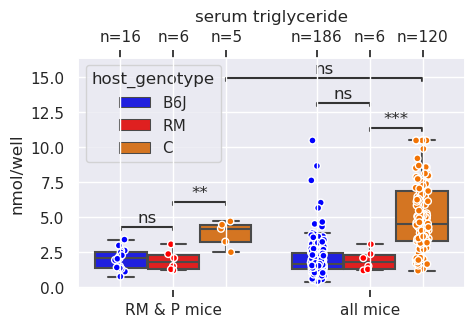

In [70]:
meta_tri = metadata.groupby('host_subject_id_bmfz').head(1).copy()
if meta_tri[meta_tri['generation'] == 'rm'].shape[0] < 12:
    meta_tri['category'] = meta_tri['generation'].apply(lambda x: 'RM & P mice' if x in ['P','RM'] else 'all mice')
    dupl_rm = meta_tri[meta_tri['generation'] == 'RM'].copy()
    dupl_rm['category'] = 'all mice'
    meta_tri = pd.concat([meta_tri, dupl_rm]).reset_index()

fig, axes = plt.subplots(1,1,figsize=(5,3))

hue_order = ['B6J','RM','C']
sns.boxplot(data=meta_tri, y='serum_triglyceride', x='category', hue='host_genotype', palette=COLORS, ax=axes, 
            hue_order=hue_order,
            dodge=True, fliersize=0)

sns.stripplot(data=meta_tri, y='serum_triglyceride', x='category', hue='host_genotype', palette=COLORS, ax=axes, 
              hue_order=hue_order,
              dodge=True, edgecolor='white', linewidth=1, legend=None)

annotator = Annotator(axes, 
    [(('RM & P mice', 'RM'), ('RM & P mice', 'B6J')), 
     (('RM & P mice', 'RM'), ('RM & P mice', 'C')), 
     
     (('all mice', 'RM'), ('all mice', 'C')), 
     (('all mice', 'RM'), ('all mice', 'B6J')), 
     
     (('RM & P mice', 'C'), ('all mice', 'C')), 
     ], 
    data=meta_tri, x='category', y='serum_triglyceride', hue='host_genotype', hue_order=hue_order)
annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default")
_ = annotator.apply_and_annotate()


axes.set_ylabel('nmol/well')
axes.set_xlabel('')
axes.set_title('serum triglyceride')

nums = meta_tri.dropna(subset=['serum_triglyceride']).groupby(['category', 'host_genotype']).size()
axTop = axes.twiny()
axTop.set_xlim(axes.get_xlim())
offset = 0.27
_ = axTop.set_xticks([0-offset, 0, 0+offset, 1-offset, 1, 1+offset],
                     ['n=%i' % x for x in  nums.loc[['RM & P mice', 'all mice'],hue_order].values])


## Figure S1

In [278]:
# create an emperor plot ONLY from samples of mice, bodysites gut or skin (skip resequenced batch 2 skin samples)
_ = emperor(metadata[(metadata['host_scientific_name'] == 'mus musculus') & 
                     (metadata['host_body_site'] != 'uberon:epithelium of left lung') & 
                     (~((metadata['batch'] == "2") & (metadata['host_body_site'] == 'uberon:skin of external ear')))
                    ],
            res_both['beta_diversity']['results'], fp_results='Generated/Emperor', infix='_gutskin', dry=False, wait=False)

Using existing results from '.anacache/df8e4c26f33a99e6c58df1b38eca7f50.emperor'. 


Use `Generated/Emperor/emperor-pcoa_gutskin_unweighted_unifrac` to upload to `view.qiime2.org`
see Figure 2, but load settings from file `EmperorSettings/emp_settings_gutANDskin.json`
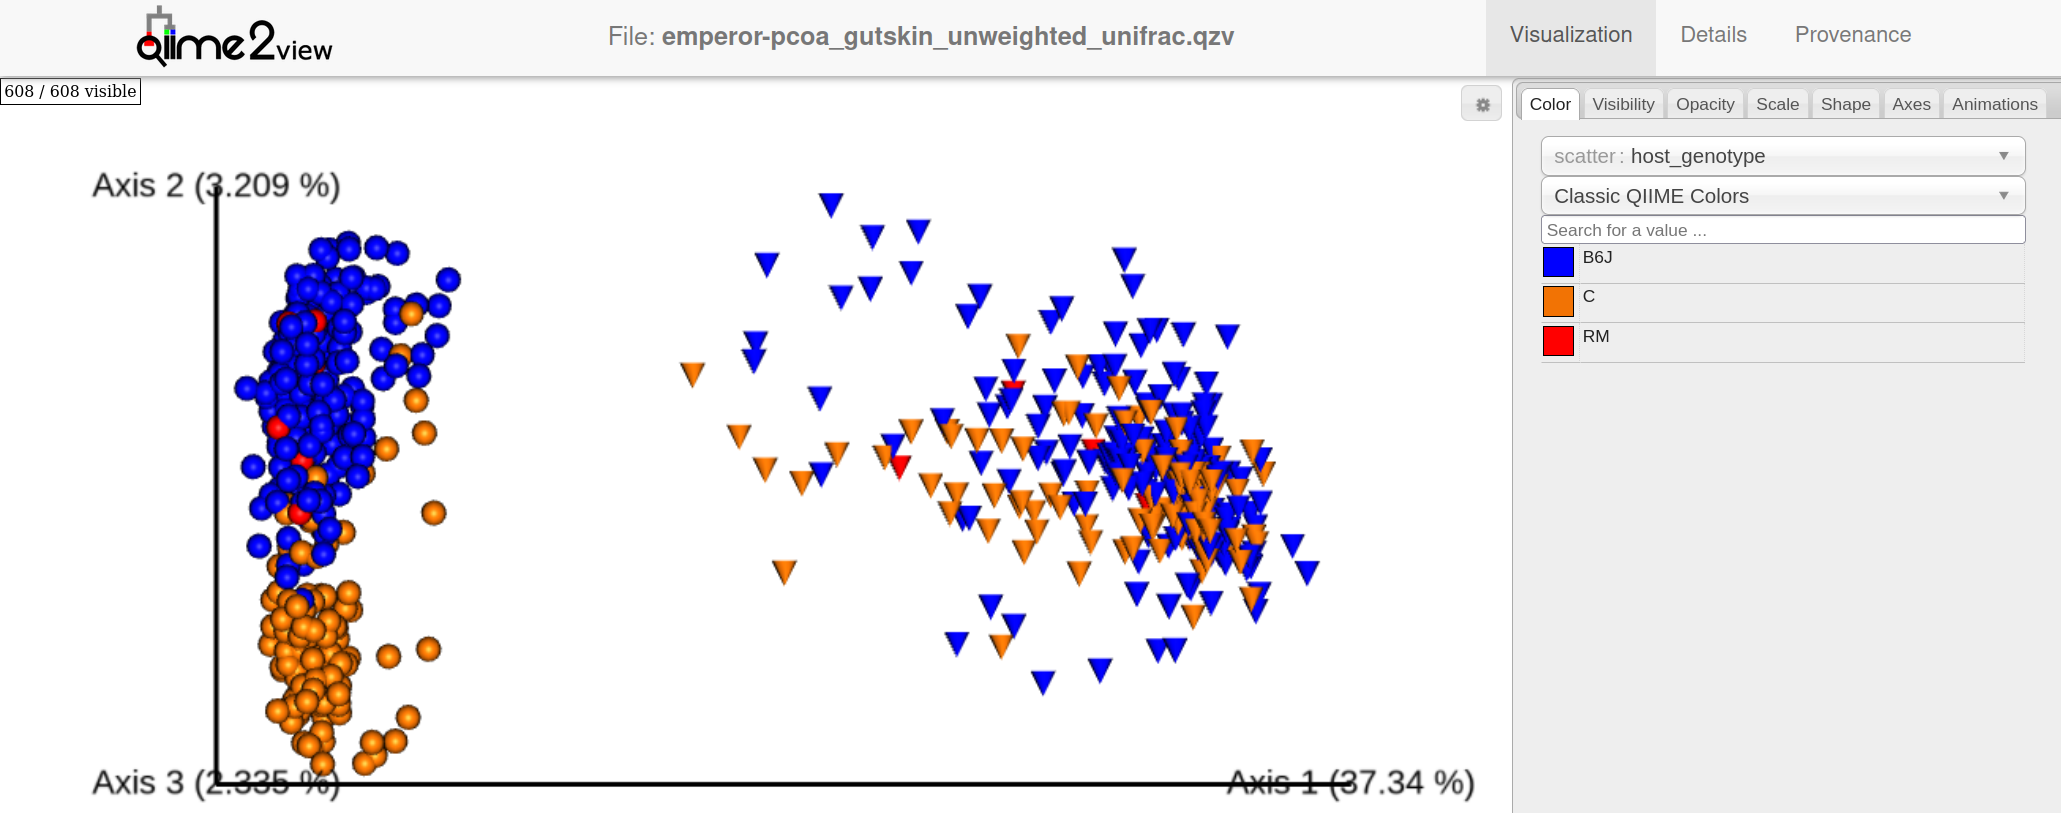

## Figure S2
Use `Generated/Emperor/emperor-pcoa_skin_weighted_unifrac.gzv` to upload to `view.qiime2.org`

### Panel A
see Figure 2, but load settings from file `EmperorSettings/emp_settings_skin_panelA.json`
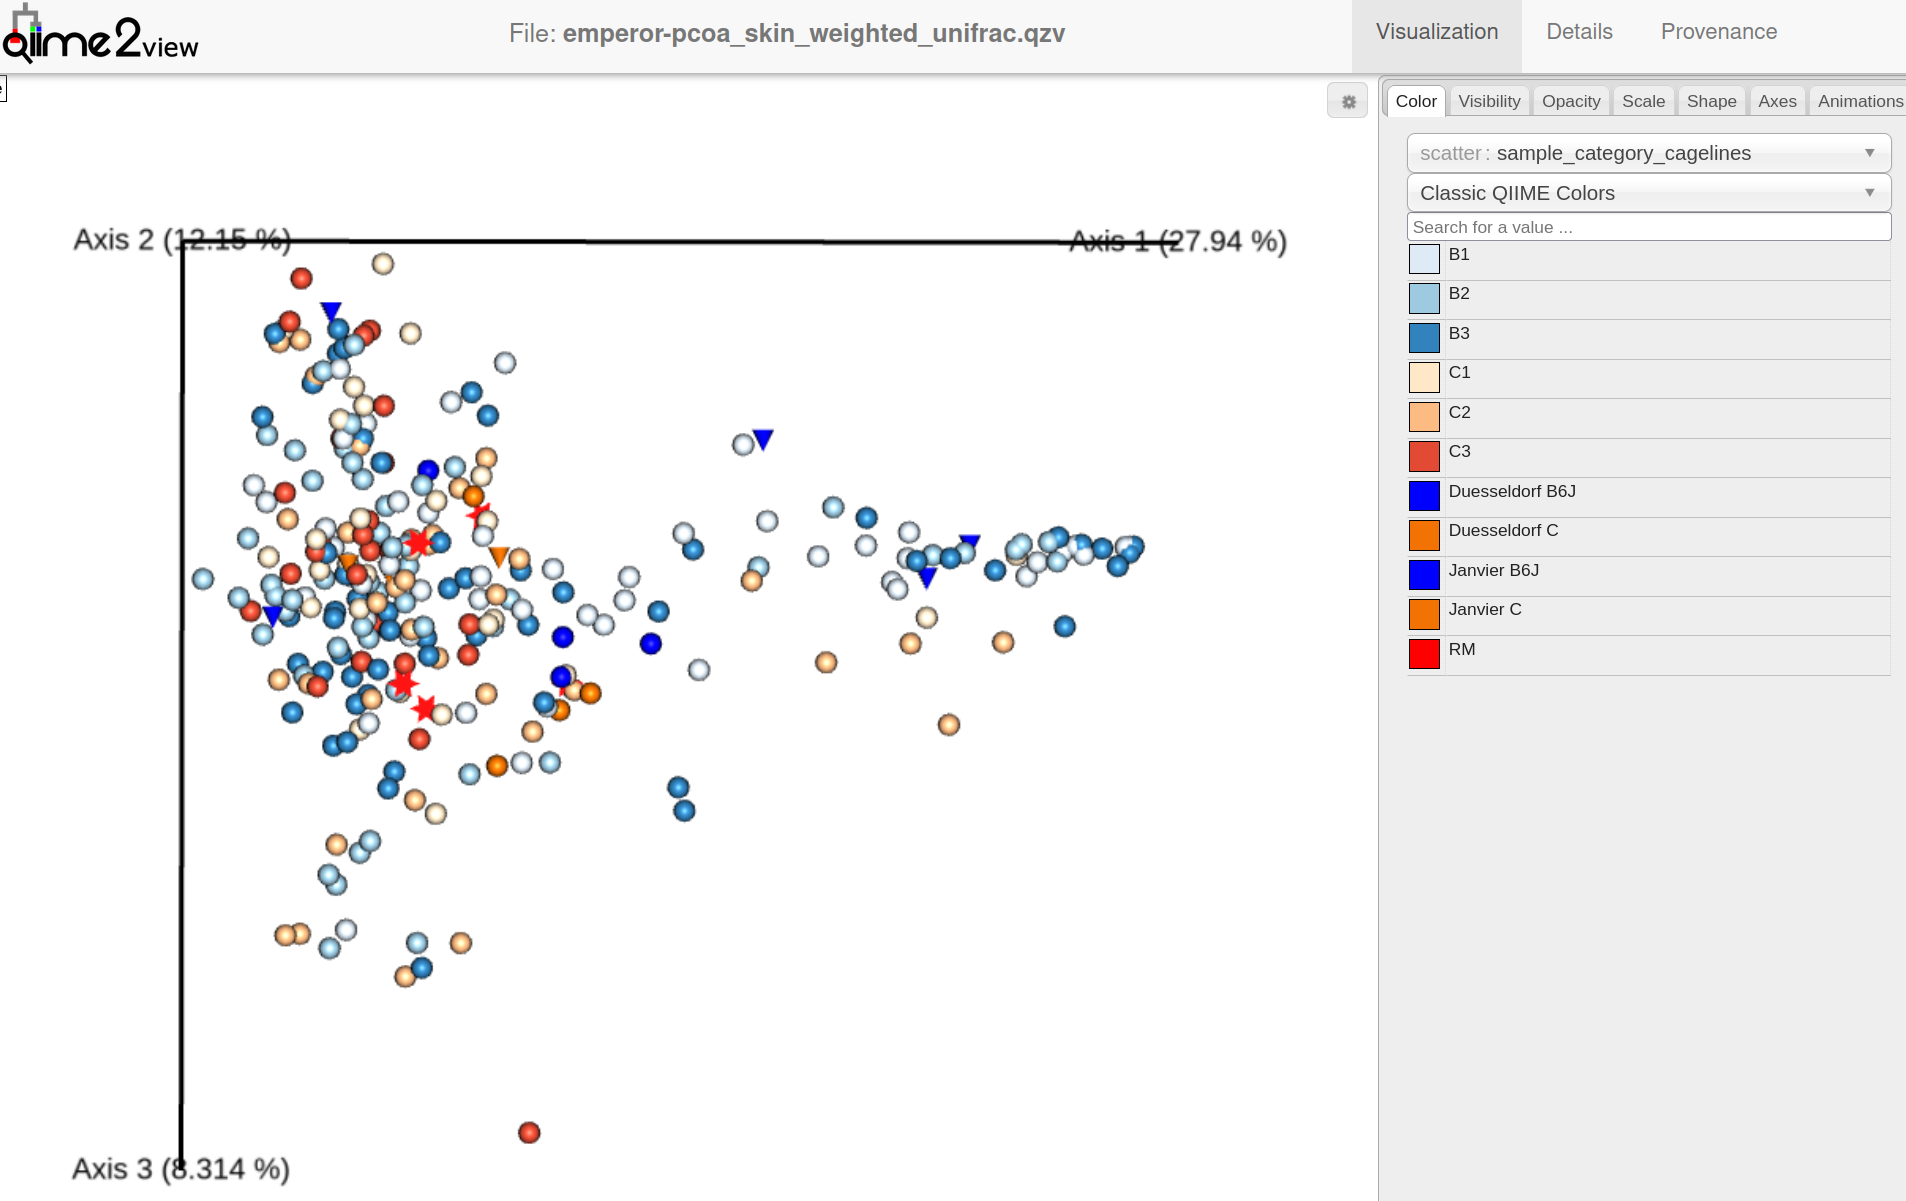

### Panel B
see Figure 2, but load settings from file `EmperorSettings/emp_settings_skin_panelB.json`
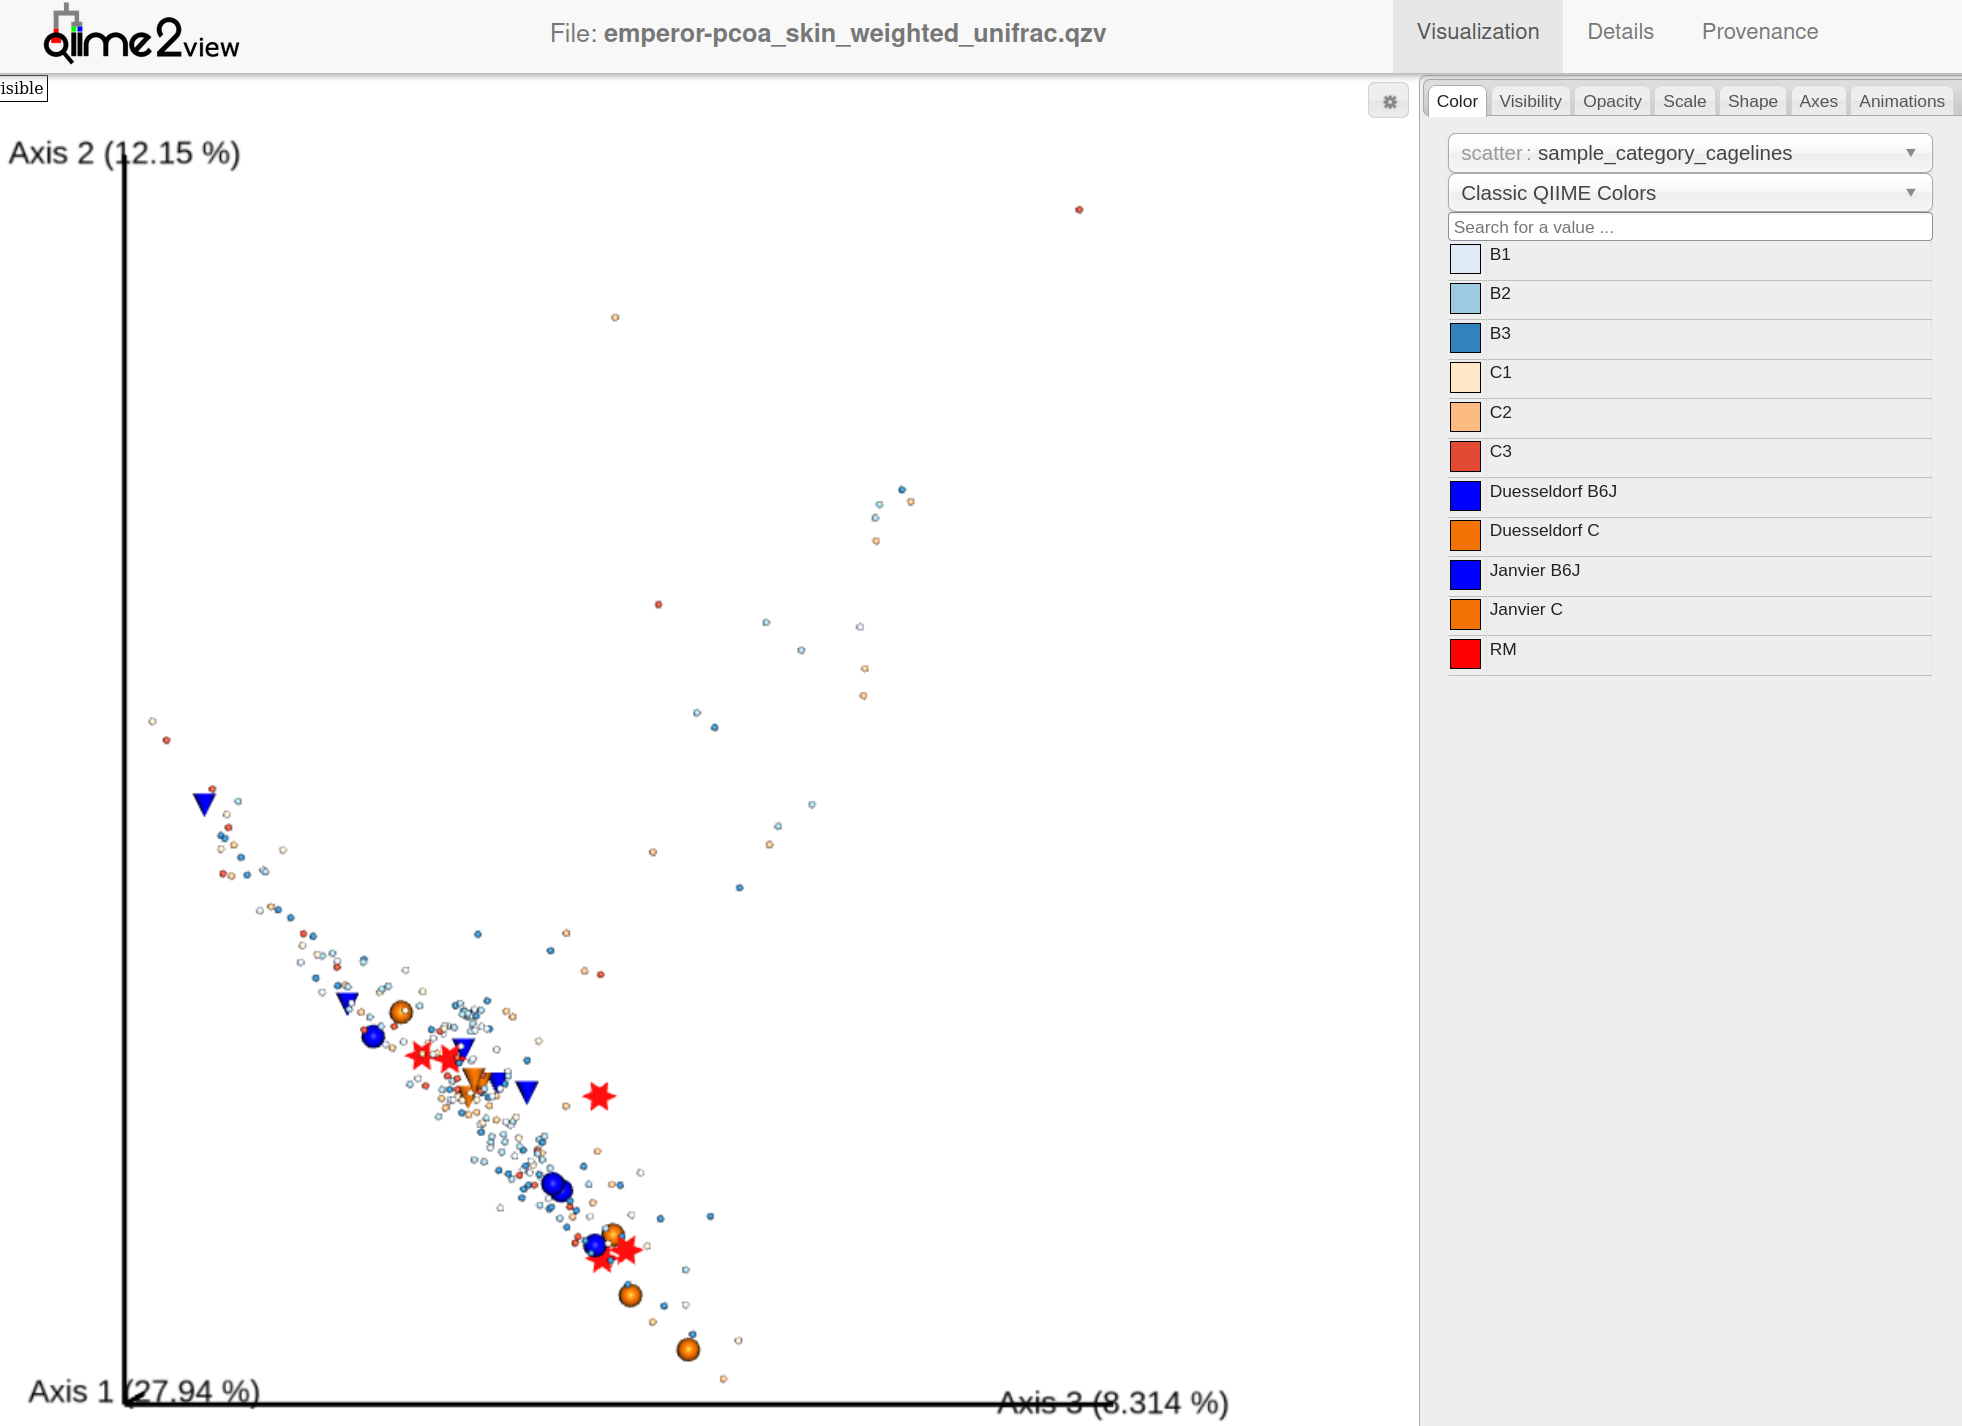

### Panel C
see Figure 2, but load settings from file `EmperorSettings/emp_settings_skin_panelC.json`
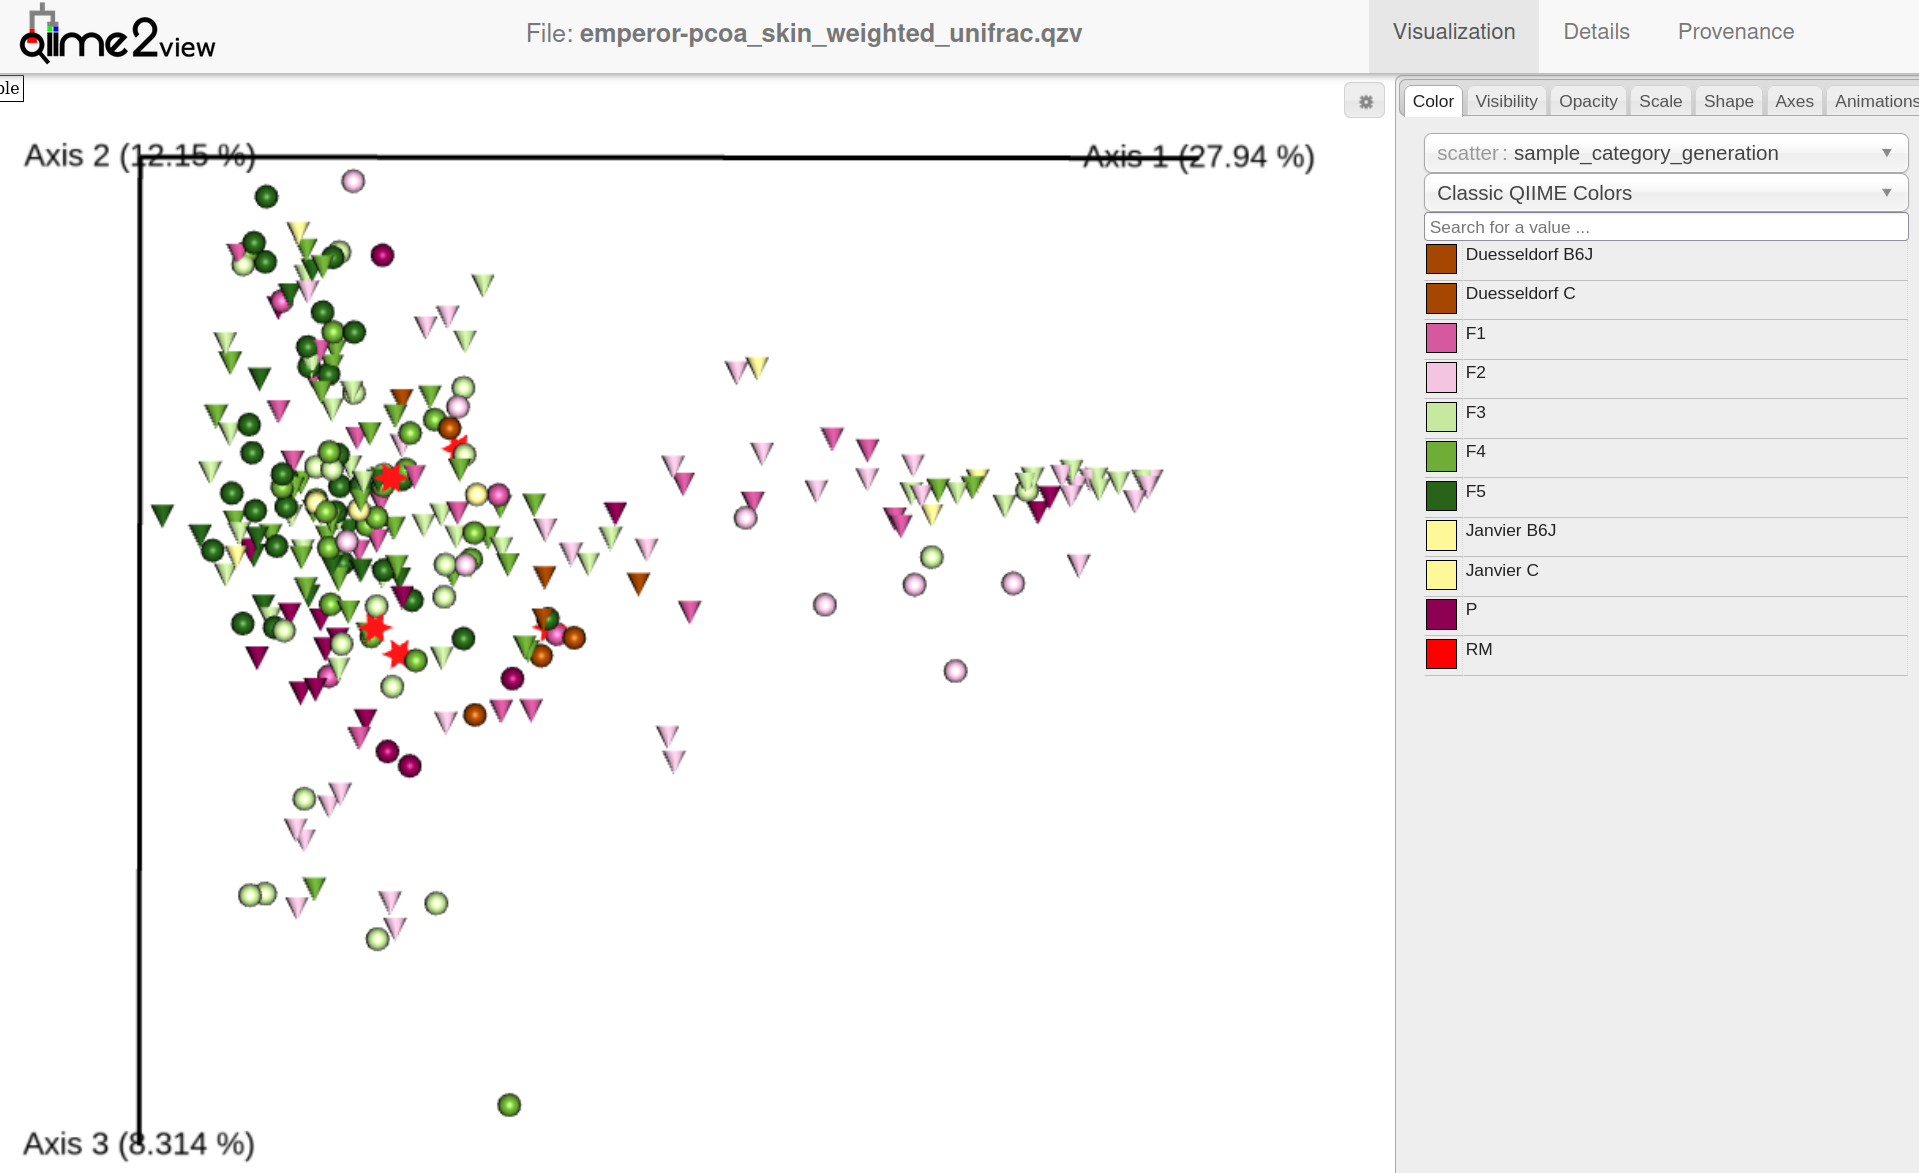

### Panel D
see Figure 2, but load settings from file `EmperorSettings/emp_settings_skin_panelD.json`
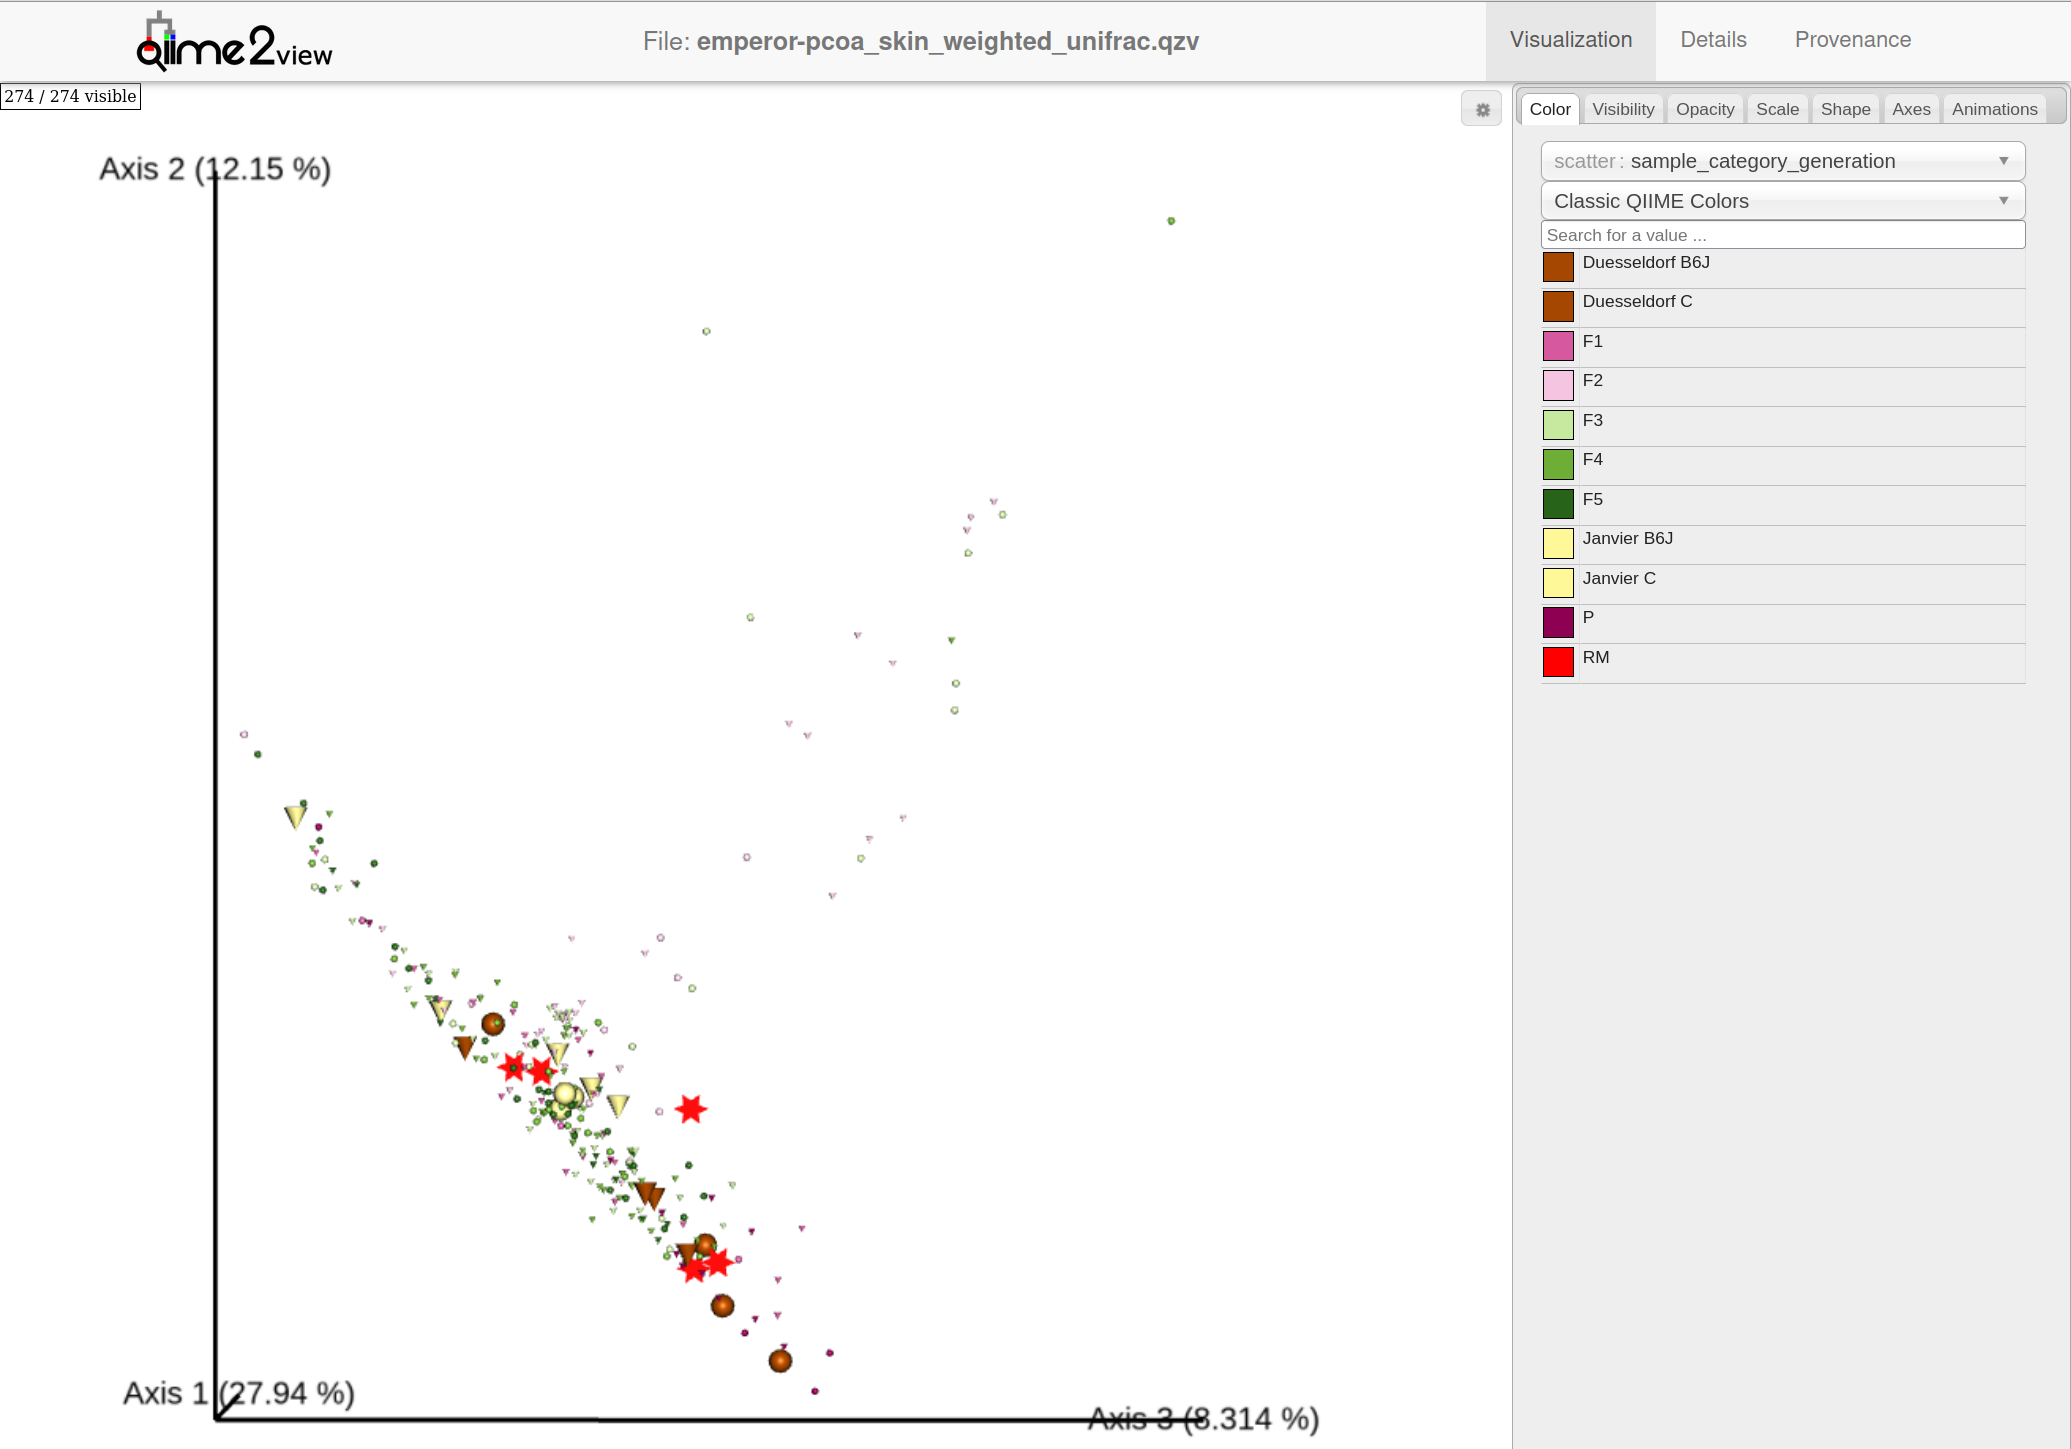

## Figure S3: <span style="color:red">Anna</span>

## Figure S4: <span style="color:red">Anna</span>

## Figure S5
### Panel A: <span style="color:red">Anna</span>
### Panel B: <span style="color:red">Anna</span>
### Panel C: <span style="color:red">Anna</span>
### Panel D: <span style="color:red">Anna</span>
### Panel E: <span style="color:red">Anna</span>

## Figure S6
### Panel A: <span style="color:red">Anna</span>
### Panel B: <span style="color:red">Anna</span>
### Panel C: <span style="color:red">Anna</span>
### Panel D: <span style="color:red">Anna</span>
### Panel E: <span style="color:red">Anna</span>

## Figure S7
### Panel A

512 taxa left after collapsing to Genus.
274 samples left with metadata and counts.
raw counts: 274
raw meta: 274
meta with counts: 274 samples x 94 fields
counts with meta: 274
saved plotting 0 boxes.


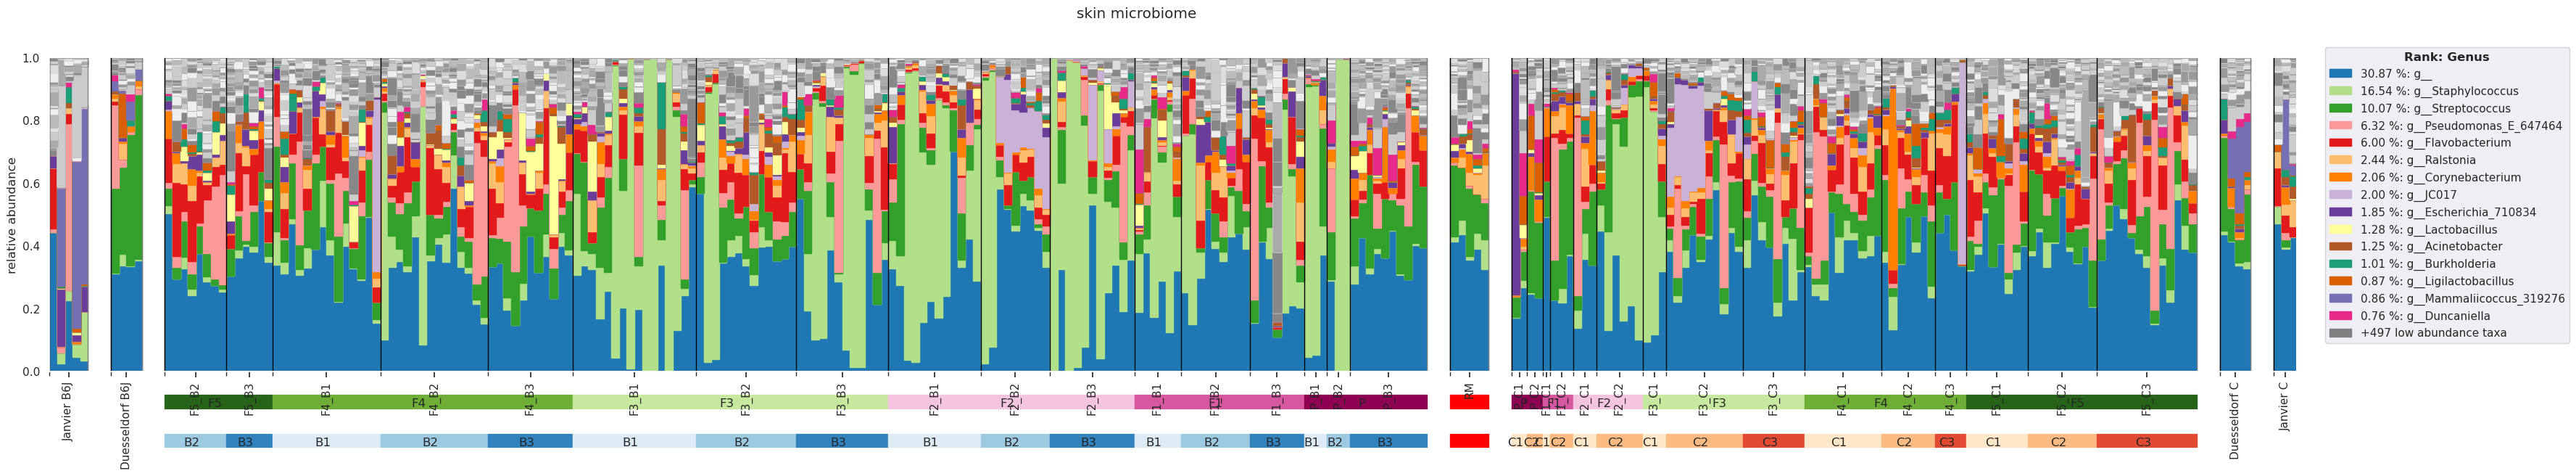

In [71]:
drawTaxBarplot(res_skin, meta_skin, title='skin microbiome', minreadnr=60*60*0.5)

## Figure S8
### Panel A

In [72]:
def get_type(row):
    if row['Source'] == 'Unknown':
        return row['Source']
    elif row['Source'] == 'control_bedding':
        return "bedding"
    elif row['Source'] == 'control_food':
        return "food"
    elif row['Source'] == row['host_genotype']:
        return "feces from matching host genotype"
    elif row['Source'] != row['host_genotype']:
        return "feces from opposing host genotype"

meta_st2_gs = metadata[
                       (metadata['host_scientific_name'] != 'callithrix jacchus') &
                        metadata['sample_type'].isin(['control bedding','control food','skin of external ear','colon content'])
                      ].copy().fillna({'generation': 'control'})

res_impact = []
res_st2_gs = dict()
for generation, g in meta_st2_gs[meta_st2_gs['sample_type'].isin(['colon content', 'skin of external ear'])].groupby('generation'):
    meta_gen = pd.concat([g, meta_st2_gs[meta_st2_gs['sample_type'].isin(['control bedding', 'control food'])]], axis=0)
    
    meta_gen['st2_type'] = 'Sink'
    meta_gen.loc[meta_gen[meta_gen['sample_type'].isin(['control bedding', 'control food', 'colon content'])].index, 'st2_type'] = 'Source'
    meta_gen['st2_env'] = meta_gen.apply(lambda r: r['host_genotype'] if pd.notnull(r['host_genotype']) else r['sample_type'], axis=1)
    res_st2_gs[generation] = sourcetracker2(res_both['counts_plantsremoved'], meta_gen, col_envname='st2_env', col_type='st2_type', dry=False, wait=False)
    
    if res_st2_gs[generation]['results'] is not None:
        d = res_st2_gs[generation]['results'].stack().reset_index().rename(columns={0: 'impact'}).merge(metadata[['host_genotype','generation','geo_loc_name']], left_on='Sink', right_index=True, how='left')
        d['type'] = d.apply(get_type, axis=1)
        d['generation'] = generation.replace('control', 'Controls')
       
        res_impact.append(d)
res_impact = pd.concat(res_impact)

Reduced to 100 samples (feature-table had 779, metadata had 100 samples)
Using existing results from '.anacache/8ae6fef07460b065c0455f6caa638552.sourcetracker2'. 
Reduced to 120 samples (feature-table had 779, metadata had 120 samples)
Using existing results from '.anacache/f5f686c44f2532bfd64ff61539a2bf36.sourcetracker2'. 
Reduced to 144 samples (feature-table had 779, metadata had 144 samples)
Using existing results from '.anacache/2de23b5d0b5c35f01a7278adbc7c7d82.sourcetracker2'. 
Reduced to 144 samples (feature-table had 779, metadata had 144 samples)
Using existing results from '.anacache/0b6705d6d7184a9b4b9bb199e4883893.sourcetracker2'. 
Reduced to 108 samples (feature-table had 779, metadata had 108 samples)
Using existing results from '.anacache/28e5b9e8594a8f98a5cc0cb04eefcf6e.sourcetracker2'. 
Reduced to 52 samples (feature-table had 779, metadata had 52 samples)
Using existing results from '.anacache/30db3a1c5b49c11fa2cadf746e620fa7.sourcetracker2'. 
Reduced to 22 samples (f

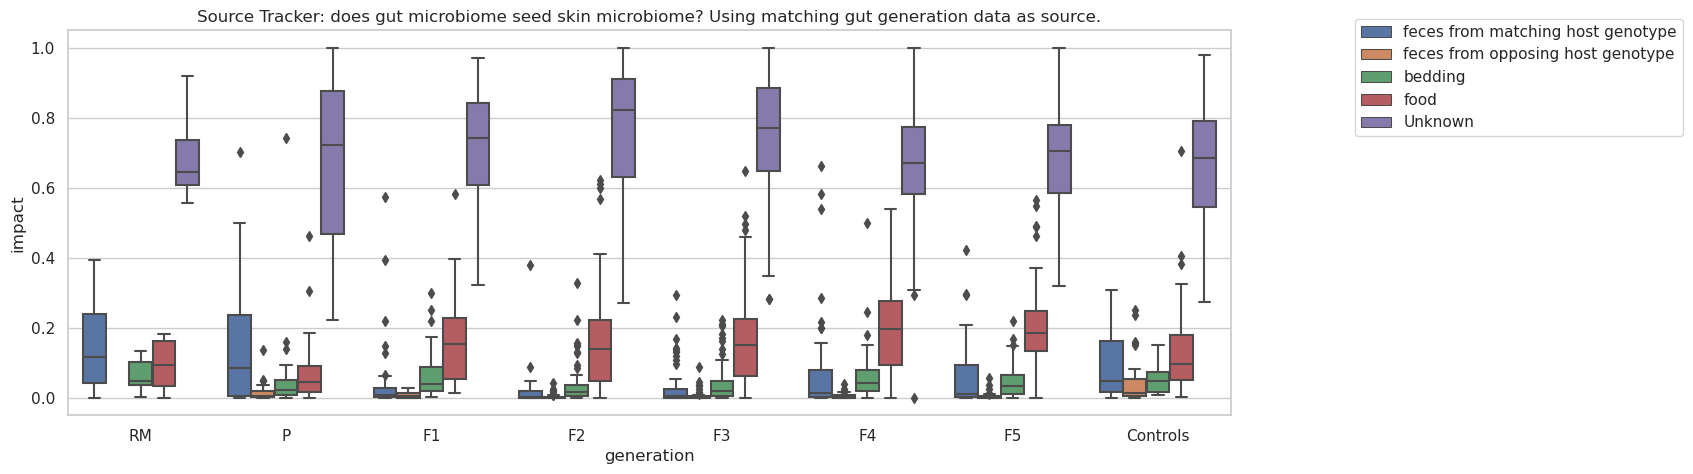

In [73]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,1,figsize=(15,5))
sns.boxplot(data=res_impact, y='impact', hue='type', x='generation', order=ORDER_GENERATIONS, ax=axes,
            hue_order=['feces from matching host genotype', 'feces from opposing host genotype', 'bedding', 'food', 'Unknown'])
axes.legend(bbox_to_anchor=(1.1, 1.05))
_ = axes.set_title("Source Tracker: does gut microbiome seed skin microbiome? Using matching gut generation data as source.")

## Figure S9
### Panel A

21 taxa left after collapsing to Phylum.
452 samples left with metadata and counts.
13 taxa left after filtering low abundant.


/homes/sjanssen/Git/sjanssen2/ggmap/ggmap/snippets.py:786: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  meta['help_plottaxonomy_level_0'] = 'all'


raw counts: 677
raw meta: 453
meta with counts: 452 samples x 108 fields
counts with meta: 452


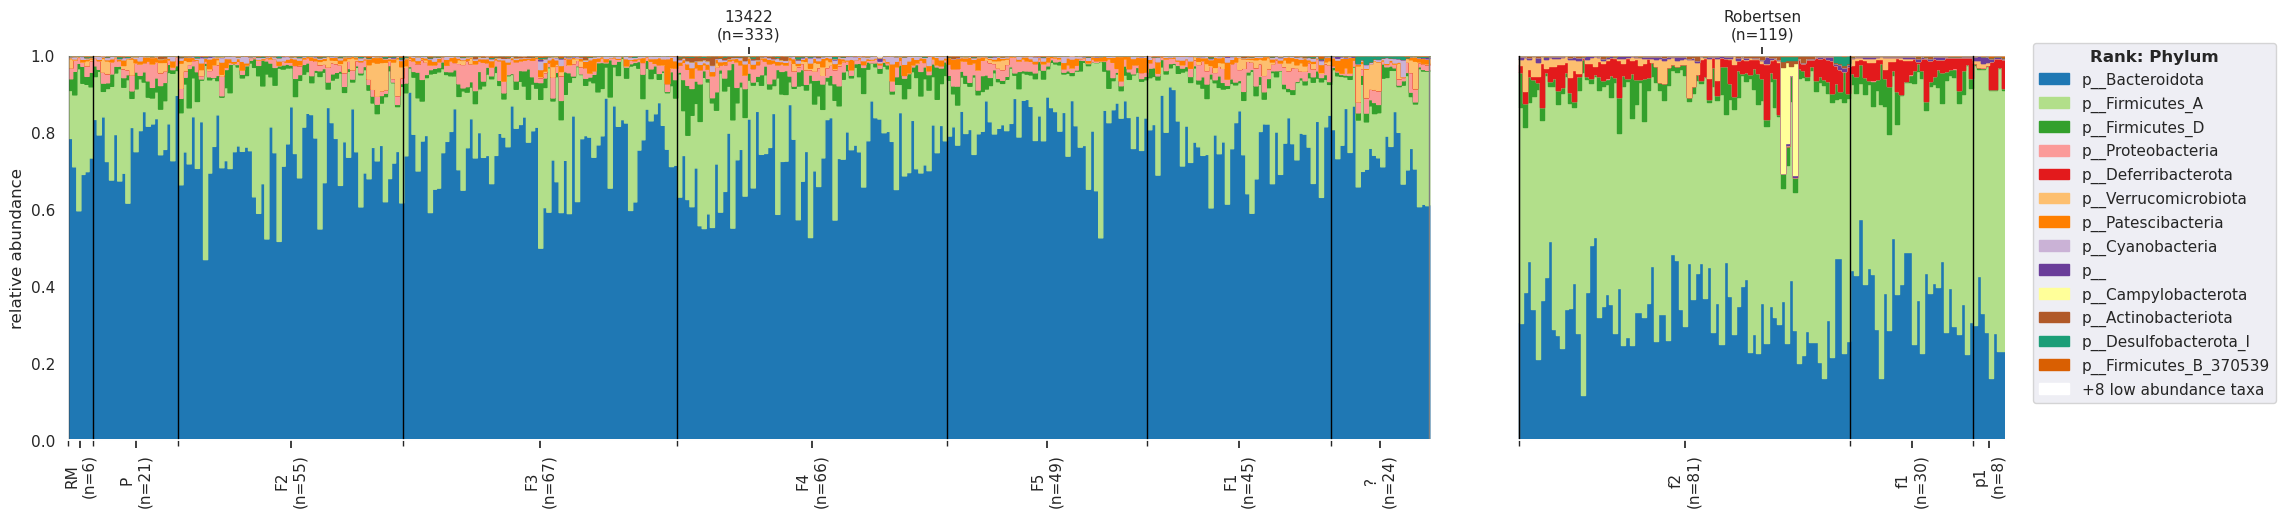

In [74]:
p = plotTaxonomy(res_rob['counts_plantsStillIn'], meta_rob[meta_rob['host_body_site'] == 'uberon:colon'].fillna('?'), file_taxonomy=res_rob['taxonomy']['RDP']['results']['Taxon'],
                 group_l1='qiita_study_id', rank='Phylum', group_l2='generation',
                 print_sample_labels=False, minreadnr=1000)
p[0].set_size_inches((25, 5))